<a href="https://colab.research.google.com/github/nafiislam/cse-326-collab-repo/blob/main/kaggle_ct_scan_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-Getting Started

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/covid19-ct-scans
!mkdir ../input
!mkdir ../input/covid19-ct-scans
!unzip covid19-ct-scans.zip -d ../input/covid19-ct-scans

This is a simple kernel to show how to use this dataset, as well as explain its contents.

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt

To make things easier, I created a `metadata.csv` file with all the filepaths organized in it.

In [ ]:
# Read and examine metadata
raw_data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
raw_data.sample(5)

ct_scan  \
10  ../input/covid19-ct-scans/ct_scans/radiopaedia...   
6   ../input/covid19-ct-scans/ct_scans/coronacases...   
15  ../input/covid19-ct-scans/ct_scans/radiopaedia...   
0   ../input/covid19-ct-scans/ct_scans/coronacases...   
4   ../input/covid19-ct-scans/ct_scans/coronacases...   

                                            lung_mask  \
10  ../input/covid19-ct-scans/lung_mask/radiopaedi...   
6   ../input/covid19-ct-scans/lung_mask/coronacase...   
15  ../input/covid19-ct-scans/lung_mask/radiopaedi...   
0   ../input/covid19-ct-scans/lung_mask/coronacase...   
4   ../input/covid19-ct-scans/lung_mask/coronacase...   

                                       infection_mask  \
10  ../input/covid19-ct-scans/infection_mask/radio...   
6   ../input/covid19-ct-scans/infection_mask/coron...   
15  ../input/covid19-ct-scans/infection_mask/radio...   
0   ../input/covid19-ct-scans/infection_mask/coron...   
4   ../input/covid19-ct-scans/infection_mask/coron...   

                              lung_and_infection_mask  
10  ../input/covid19-ct-scans/lung_and_infection_m...  
6   ../input/covid19-ct-scans/lung_and_infection_m...  
15  ../input/covid19-ct-scans/lung_and_infection_m...  
0   ../input/covid19-ct-scans/lung_and_infection_m...  
4   ../input/covid19-ct-scans/lung_and_infection_m...

The files are provided in NifTi format (\*.nii) to read it we'll make use of the `nibabel` package.

Note: images were rotated in the source, so we'll add `np.rot90` to account for that.

In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

Let's examine a file and all available annotations

In [ ]:
# Read sample
sample_ct   = read_nii(raw_data.loc[0,'ct_scan'])
sample_lung = read_nii(raw_data.loc[0,'lung_mask'])
sample_infe = read_nii(raw_data.loc[0,'infection_mask'])
sample_all  = read_nii(raw_data.loc[0,'lung_and_infection_mask'])

Note that `512x512` is the common resolution for ct images, also there are `301` slices in this ct scan.

In [ ]:
# Examine Shape
sample_ct.shape,sample_lung.shape,sample_infe.shape,sample_all.shape

((512, 512, 301), (512, 512, 301), (512, 512, 301), (512, 512, 301))

Now lets inspect the images, as well as annotations that we have available:

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

There are 3 annotations available:
- Lung Segmentation (contains different values to account for left and right lung)
- Infection Segmentation (segmentation of radiological findings that could be COVID)
- Lung + Infection (for the sake of making it simplier)

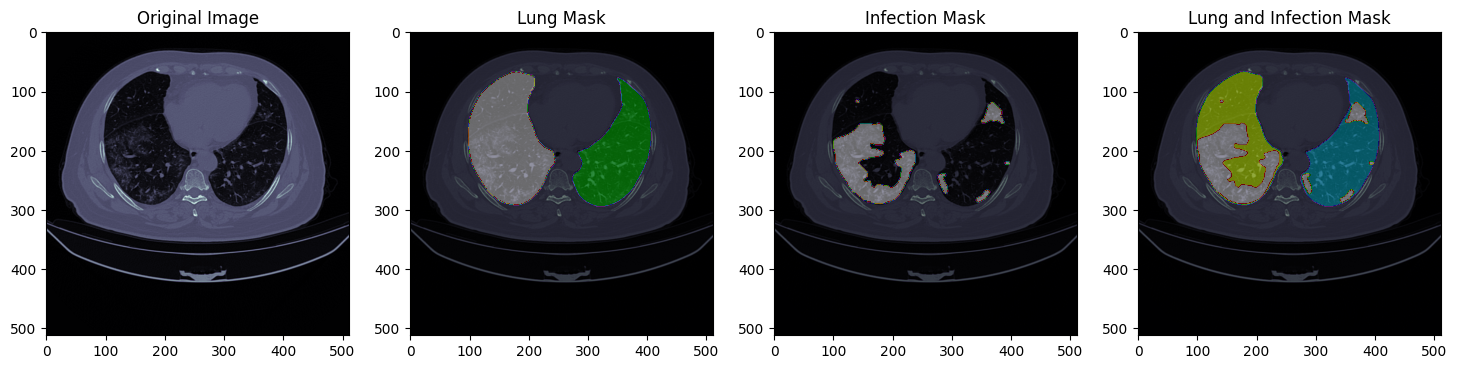

In [ ]:
# Examine one slice of a ct scan and its annotations
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

That's an example from a single slice, lets do the same for multiple slices in the same exam.

In [ ]:
def bulk_plot_sample(array_list, index_list):
    '''
    Plots multiple slices, wrapper of plot_sample
    '''
    for index_value in index_list:
        plot_sample([array_list[0][...,index_value], array_list[1][...,index_value], array_list[2][...,index_value], array_list[3][...,index_value]])

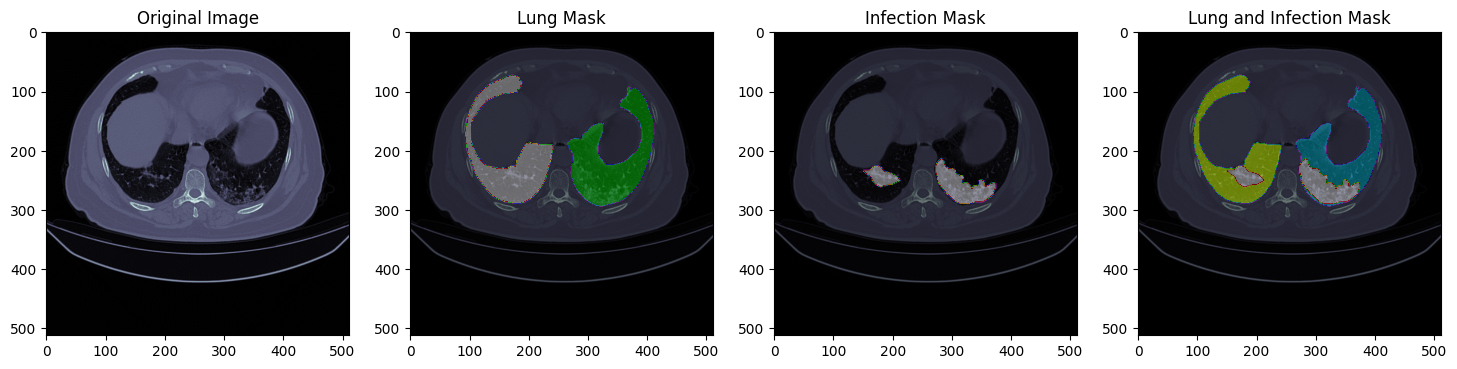

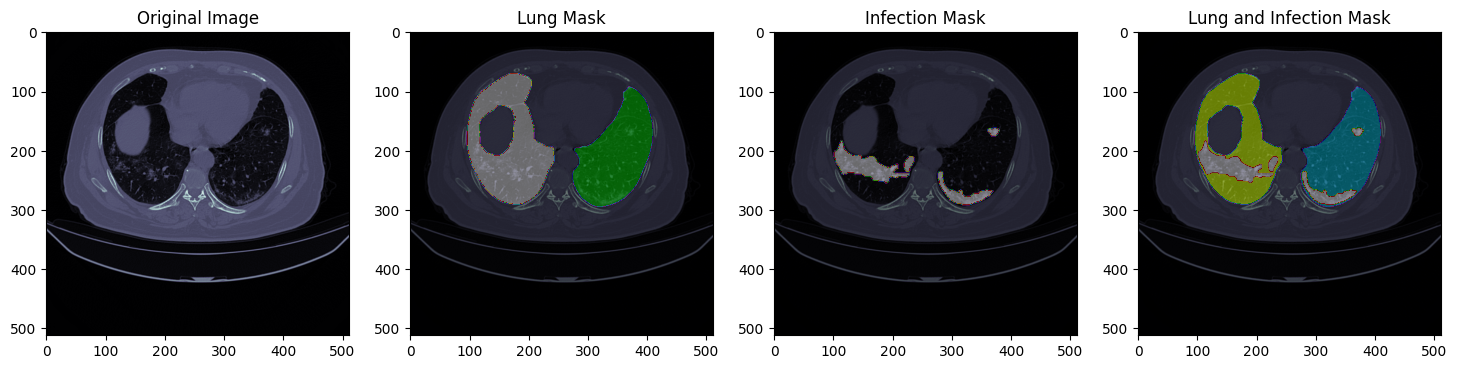

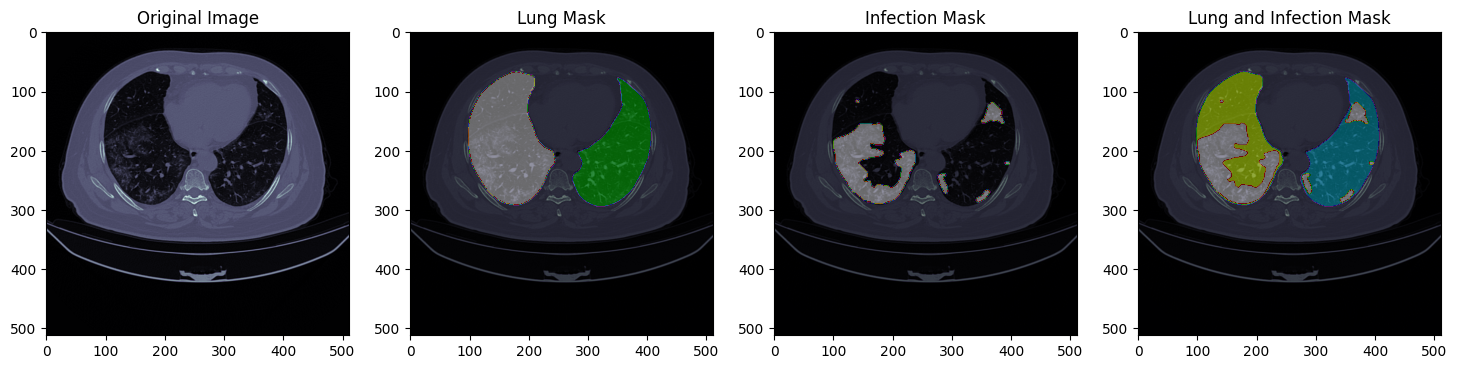

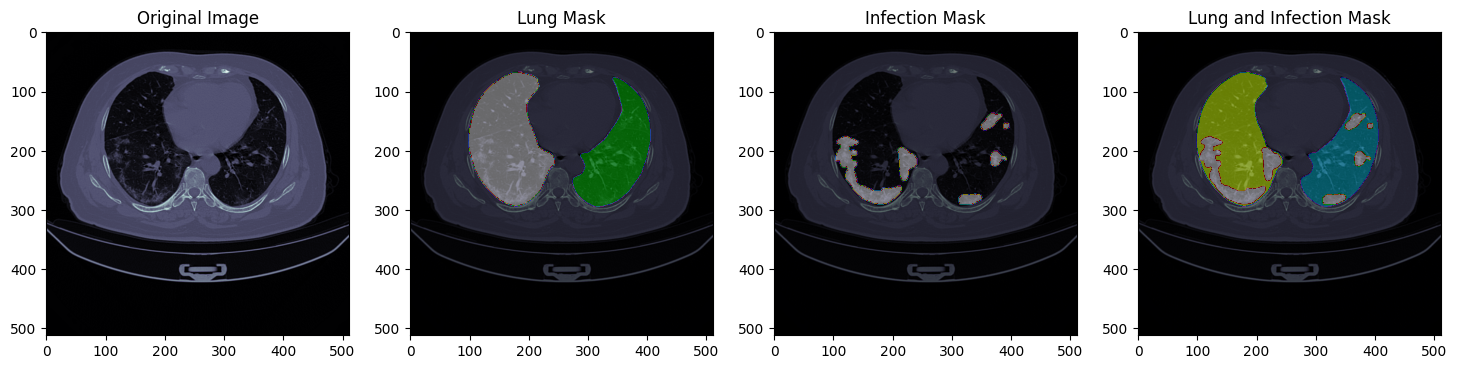

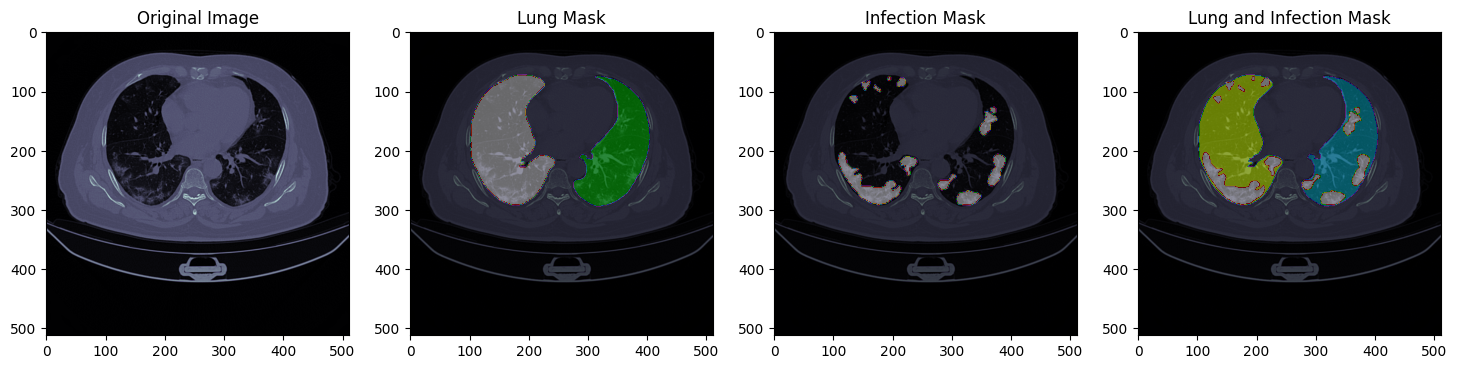

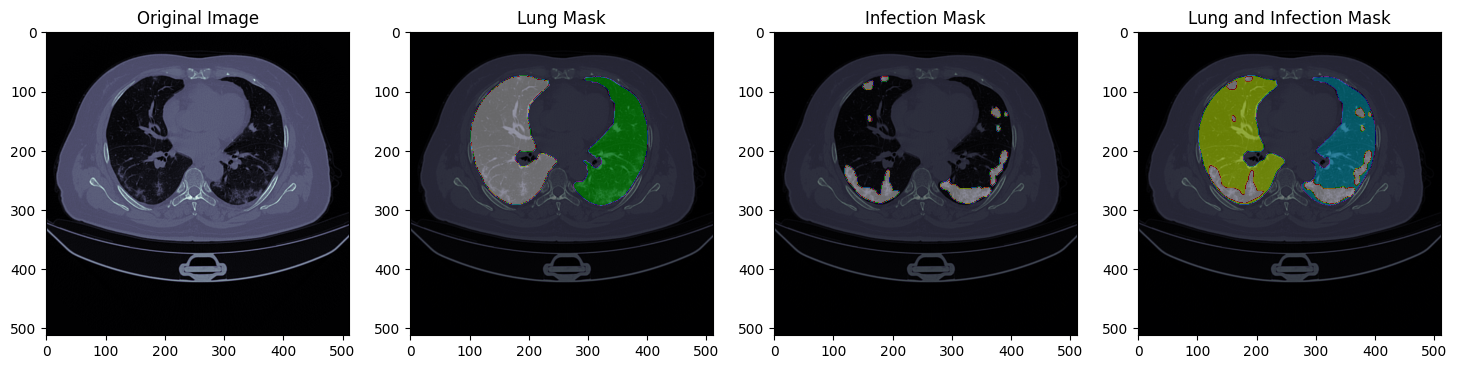

In [ ]:
# Examine multiple slices of a ct scan and its annotations
bulk_plot_sample([sample_ct, sample_lung, sample_infe, sample_all], index_list=[100,110,120,130,140,150])

From here on you should be able to model the data to your hearts content!

For any requests let me know here in this kernel or in the discussion.

Thank you!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Resize
from IPython.display import display
from torchsummary import summary


In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
X,y=[],[]
for row in raw_data.iterrows():
  data=read_nii(row[1]['ct_scan'])
  data=torch.from_numpy(data.copy()).to(device)
  data=data.permute(2,0,1)
  data=Resize((128,128))(data)
  target=read_nii(row[1]['lung_mask'])
  target=torch.from_numpy(target.copy()).to(device)
  target=target.permute(2,0,1)
  target=Resize((128,128))(target)
  y.append(target)
  X.append(data)


In [ ]:
test_index=torch.randint(len(X),size=(int(len(X)*.2),))
X_train,X_test,y_train,y_test=[X[i] for i in range(len(X)) if i not in test_index],[X[i] for i in test_index],[y[i] for i in range(len(y)) if i not in test_index],[y[i] for i in test_index]
len(X_train),len(X_test),len(y_train),len(y_test)

(16, 4, 16, 4)

In [ ]:
class UNet(nn.Module):
  def __init__(self,in_channels=1,out_channels=1):
    super(UNet,self).__init__()
    def conv1(in_channels,out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )
    def down(in_channels,out_channels):
      return nn.Sequential(
          nn.MaxPool2d(2),
          conv1(in_channels,out_channels)
      )
    def up(in_channels,out_channels):
      return nn.Sequential(
          nn.Upsample(scale_factor=2),
          conv1(in_channels,out_channels)
      )
    self.start=conv1(in_channels,16)
    self.down1=down(16,32)
    self.down2=down(32,64)
    self.down3=down(64,128)
    self.down4=down(128,256)
    self.up1=up(256,128)
    self.up2=up(256,64)
    self.up3=up(128,32)
    self.up4=up(64,16)
    self.end=nn.Conv2d(16,out_channels,1)
  def forward(self,x):
    x1=self.start(x) # 32,16,128,128
    # print(x1.shape)
    x2=self.down1(x1) # 32,32,64,64
    # print(x2.shape)
    x3=self.down2(x2) # 32,64,32,32
    # print(x3.shape)
    x4=self.down3(x3) # 32,128,16,16
    # print(x4.shape)
    x=self.down4(x4) # 32,256,8,8
    # print(x.shape)
    x=self.up1(x) # 32,128,16,16
    # print(x.shape)
    x=torch.cat([x,x4],dim=1) # 32,256,16,16
    # print(x.shape)
    x=self.up2(x) # 32,64,32,32
    # print(x.shape)
    x=torch.cat([x,x3],dim=1) #32,128,32,32
    # print(x.shape)
    x=self.up3(x) #32,32,64,64
    # print(x.shape)
    x=torch.cat([x,x2],dim=1) #32,64,64,64
    # print(x.shape)
    x=self.up4(x) #32,16,128,128
    # print(x.shape)
    x=self.end(x)
    # print(x.shape)
    # x=torch.sigmoid(x)
    # print(x.shape)
    return x


In [ ]:
model=UNet(1,3).to(device)

In [ ]:
pred=model(X[0][100:132].to(device).unsqueeze(dim=1).to(torch.float32))
print(pred[20].argmax(dim=0).unique())

tensor([0, 1, 2])


torch.Size([32, 3, 128, 128])


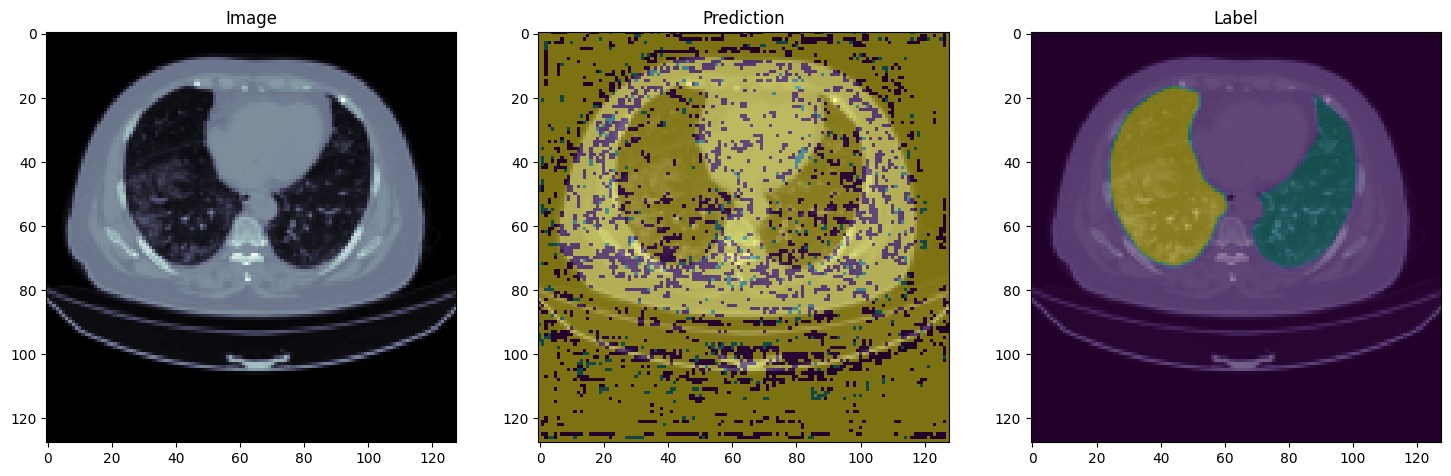

In [ ]:
def plot_pred(image,pred,label):
  fig=plt.figure(figsize=(18,15))
  plt.subplot(1,3,1)
  plt.imshow(image.cpu(),cmap='bone')
  plt.title('Image')
  plt.subplot(1,3,2)
  plt.imshow(image.cpu(),cmap='bone')
  plt.imshow(pred.argmax(dim=0).cpu(),alpha=.5)
  plt.title('Prediction')
  plt.subplot(1,3,3)
  plt.imshow(image.cpu(),cmap='bone')
  plt.imshow(label.cpu(),alpha=.5)
  plt.title('Label')
  plt.show()
print(pred.shape)
plot_pred(X[0][120],pred[20],y[0][120])

In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1)

epochs=3
batch_size=32

model.eval()
with torch.inference_mode():
  image_index=torch.randint(len(X_test),size=(1,))
  random_image=X_test[image_index]
  random_label=y_test[image_index]
  random_index=torch.randint(len(random_image),size=(batch_size,))
  test_image=random_image[random_index]
  test_label=random_label[random_index]
  test_pred=model(test_image.to(device).unsqueeze(dim=1).to(torch.float32))
  print(test_pred[10].argmax(dim=0).shape)
  # test_loss=loss_fn(test_pred.view(batch_size,3,-1),test_label.view(batch_size,-1).to(device).to(torch.int64))
  # print(f"epochs:{epoch}/{epochs}, image:{index}/{len(X_train)}, batch:{batch}/{len(image)}, train_loss:{batch_loss}, test_loss:{test_loss}")
  plot_random_index=torch.randint(len(test_image),size=(1,))
  # print(test_image.shape,test_pred[plot_random_index].shape,test_label.shape)
  plot_pred(test_image[plot_random_index].squeeze(),test_pred[plot_random_index].squeeze(),test_label[plot_random_index].squeeze())
  # print(test_pred[plot_random_index].argmax(dim=0))

epochs:0/3, image:0/17, batch:0/301, train_loss:1.2524300813674927, test_loss:1.0284981727600098


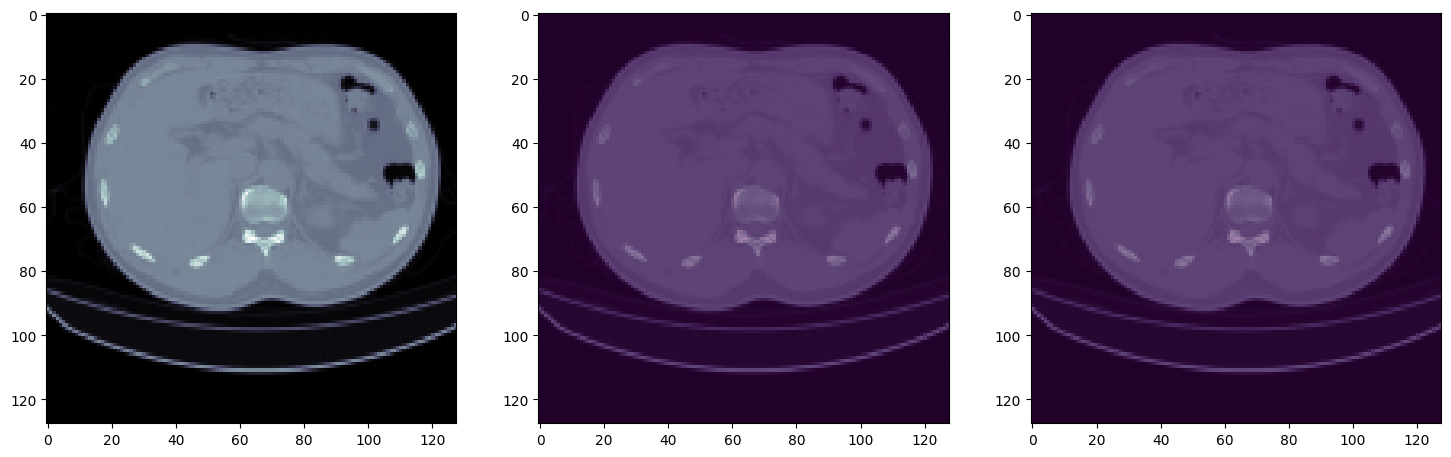

epochs:0/3, image:1/17, batch:0/200, train_loss:0.3977436423301697, test_loss:0.5417799353599548


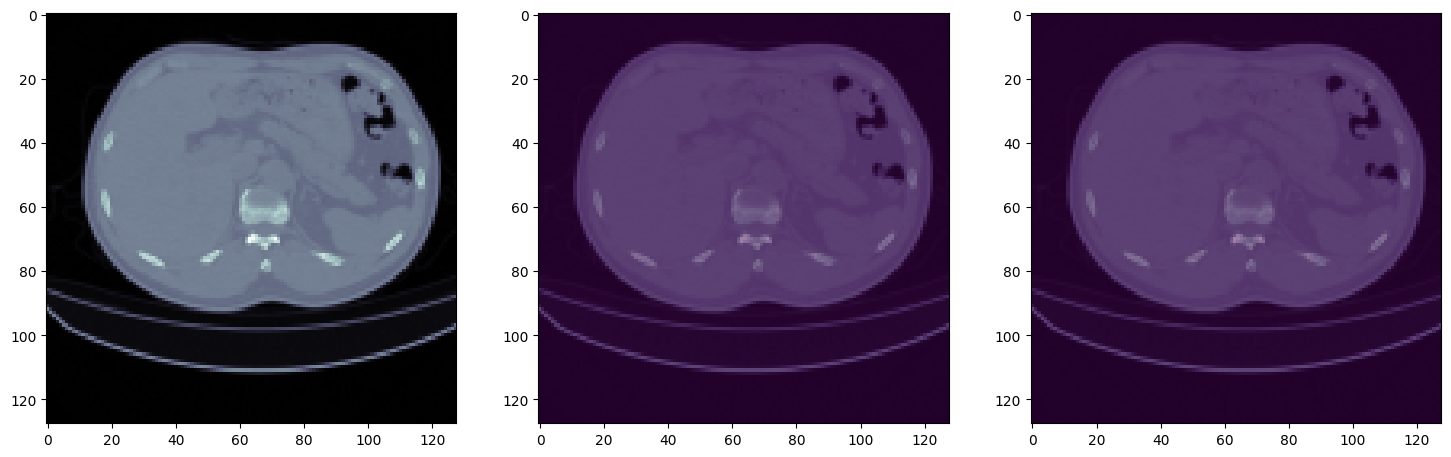

epochs:0/3, image:2/17, batch:96/270, train_loss:0.32910194993019104, test_loss:0.4306955933570862


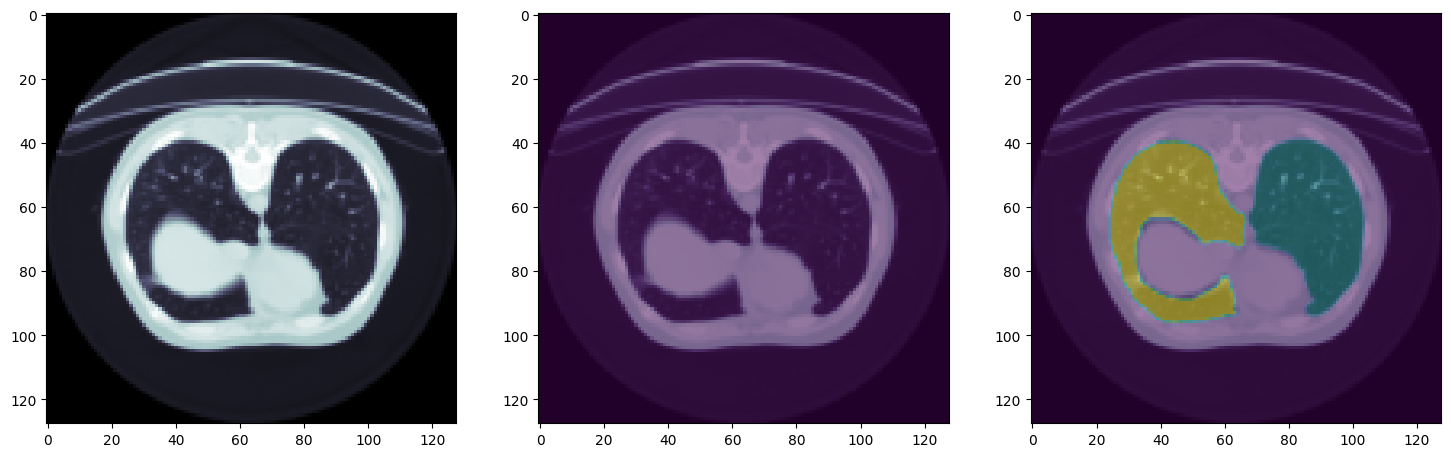

epochs:0/3, image:3/17, batch:128/290, train_loss:0.26637399196624756, test_loss:0.3123091757297516


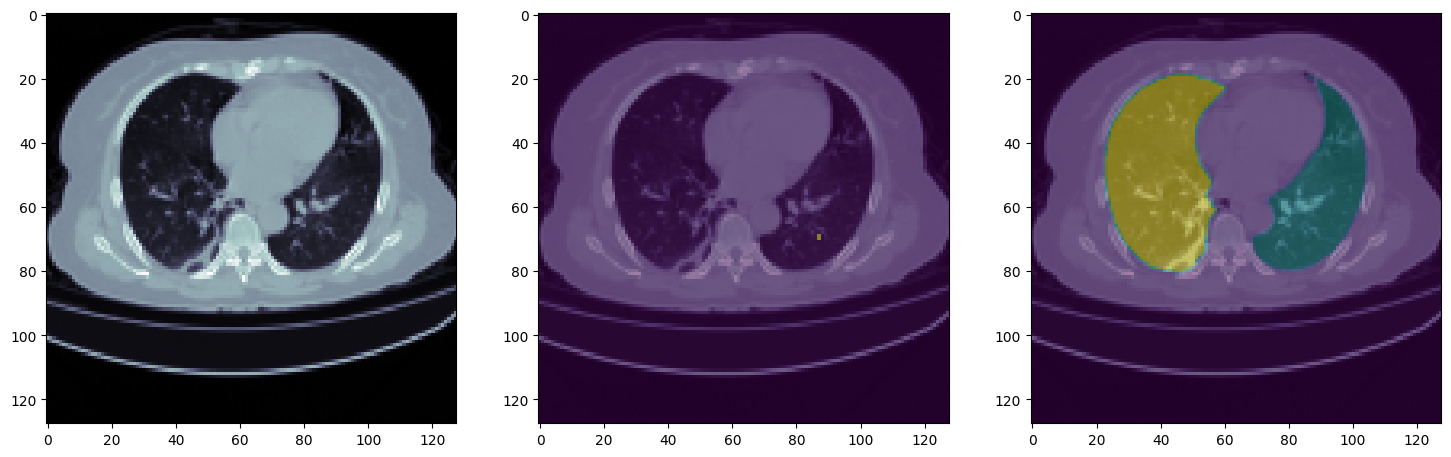

epochs:0/3, image:4/17, batch:128/213, train_loss:0.14674273133277893, test_loss:0.1377497762441635


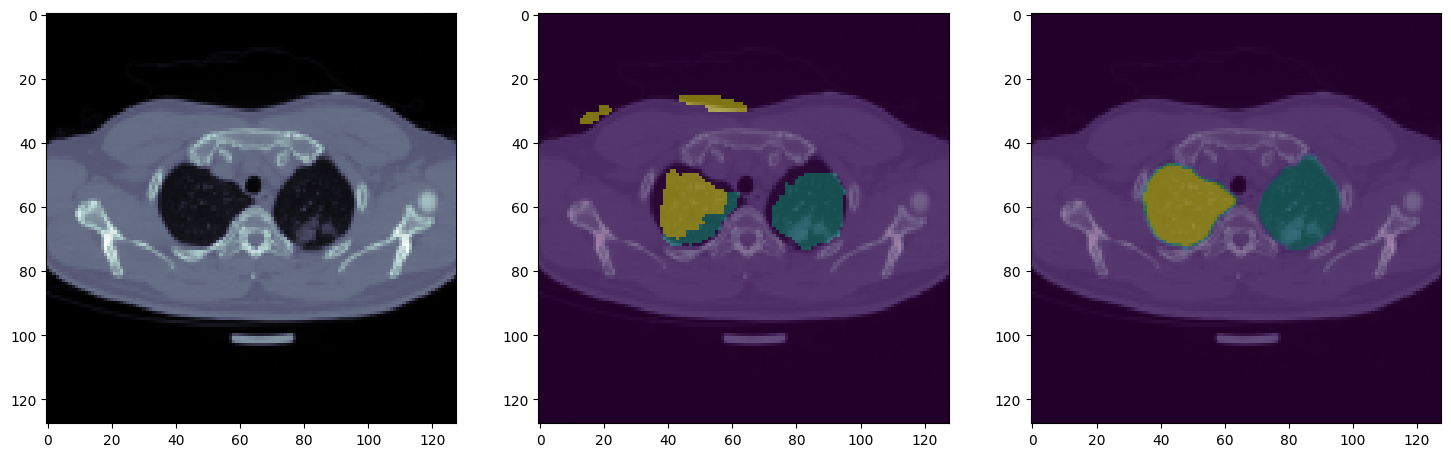

epochs:0/3, image:5/17, batch:224/249, train_loss:1.91554856300354, test_loss:0.1676257699728012


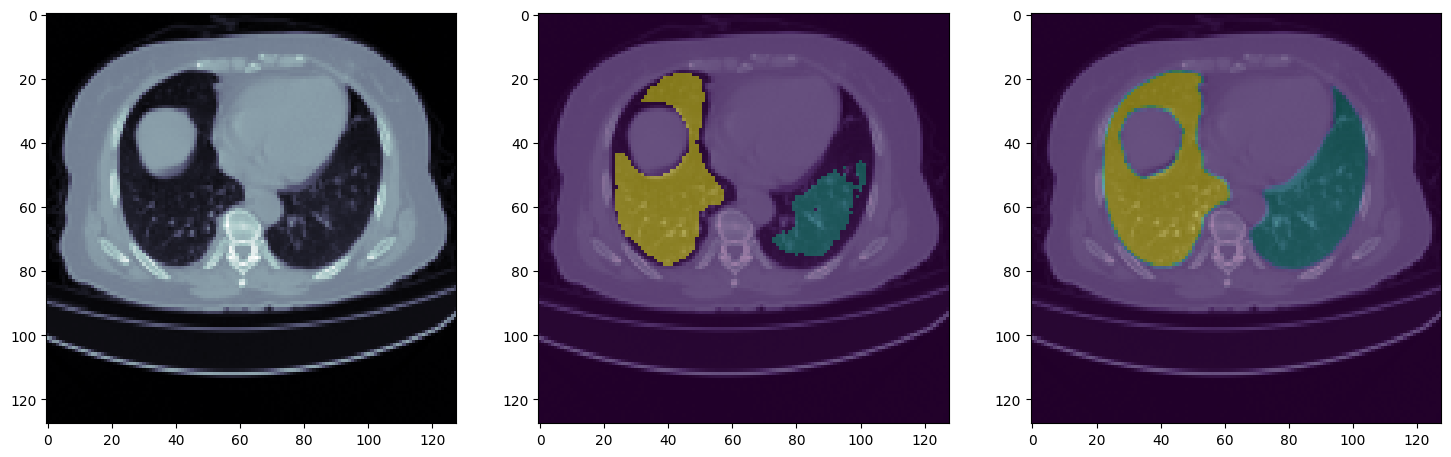

epochs:0/3, image:6/17, batch:288/301, train_loss:1.579738736152649, test_loss:0.21452248096466064


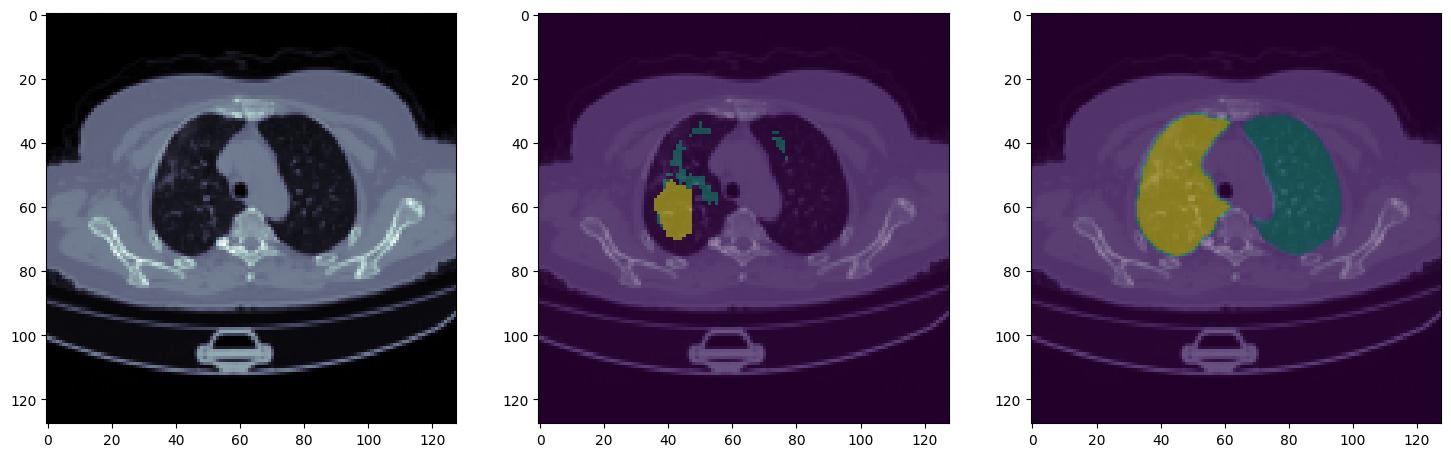

epochs:0/3, image:7/17, batch:288/301, train_loss:1.6343127489089966, test_loss:0.2076684534549713


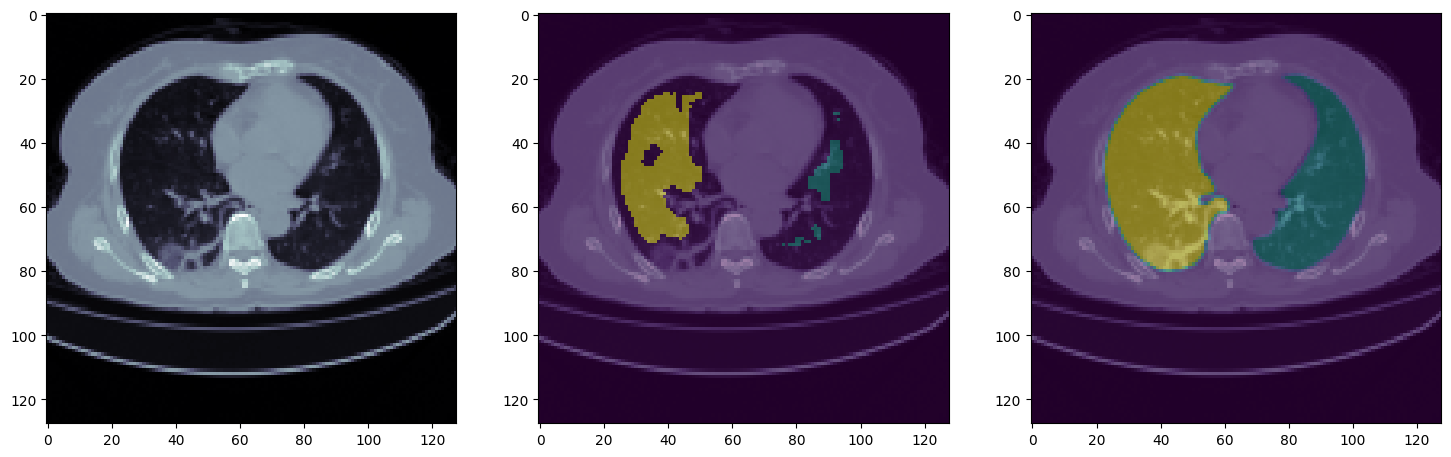

epochs:0/3, image:9/17, batch:224/418, train_loss:0.18036502599716187, test_loss:0.4123888611793518


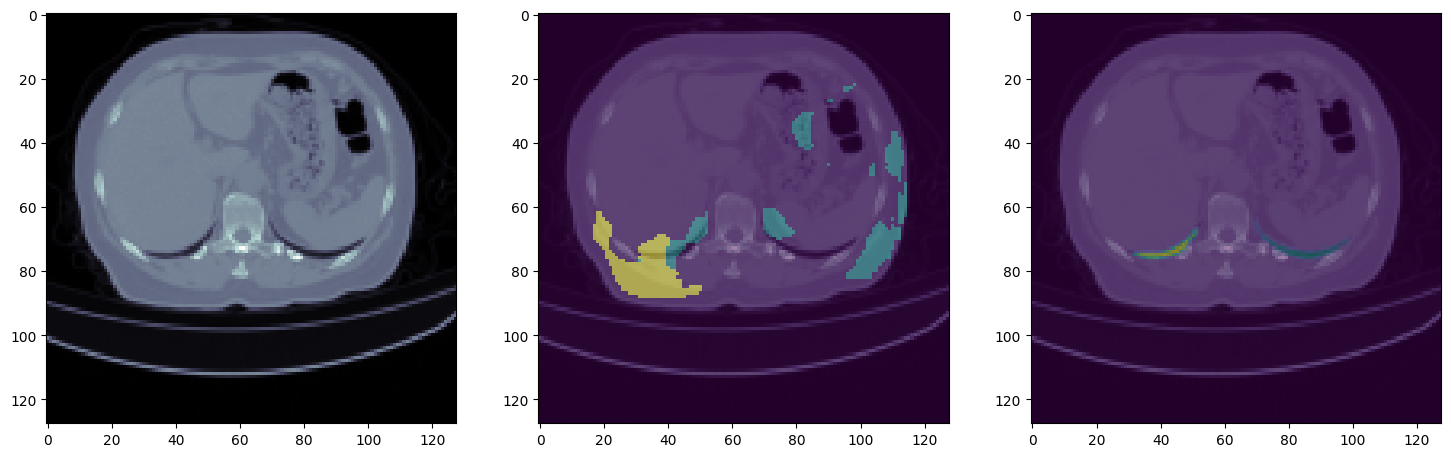

epochs:0/3, image:10/17, batch:96/110, train_loss:1.819216012954712, test_loss:0.6960607767105103


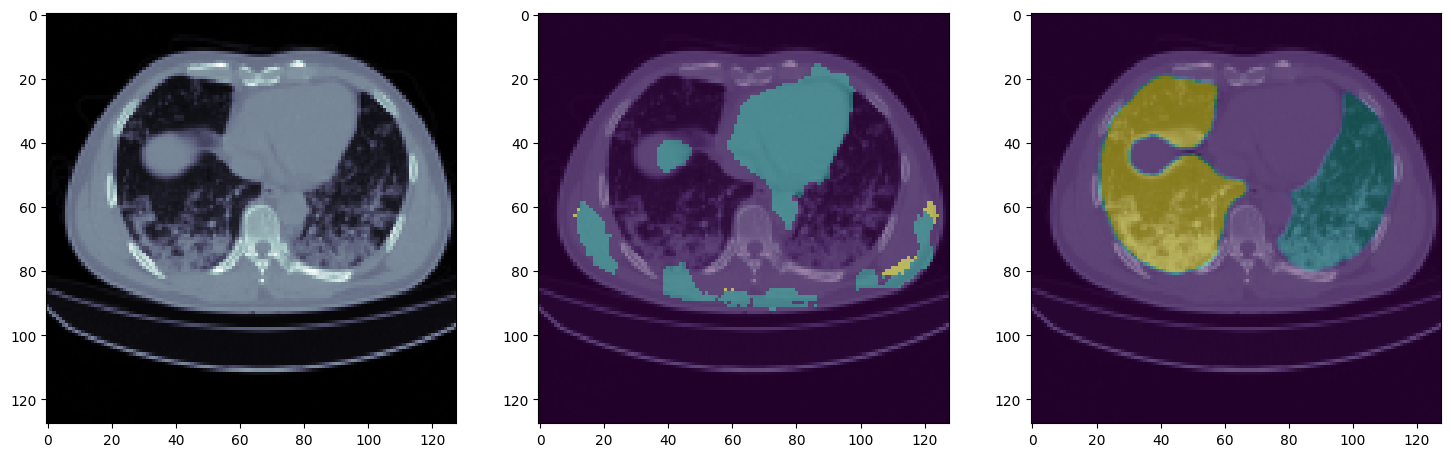

epochs:0/3, image:14/17, batch:64/93, train_loss:2.166637659072876, test_loss:0.30631938576698303


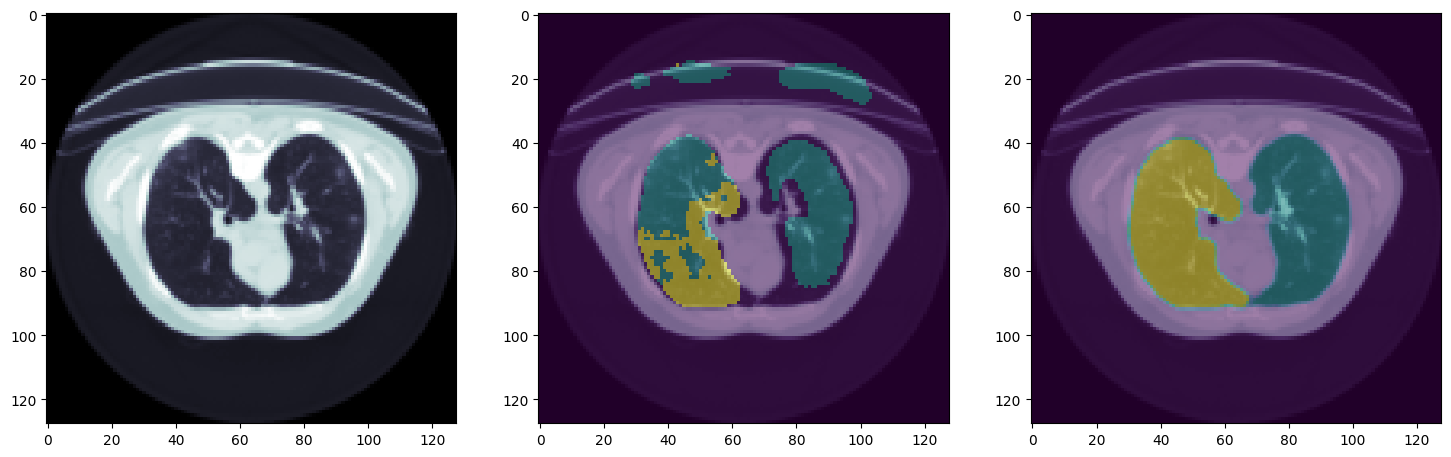

epochs:1/3, image:0/17, batch:160/301, train_loss:0.1275978535413742, test_loss:0.258156418800354


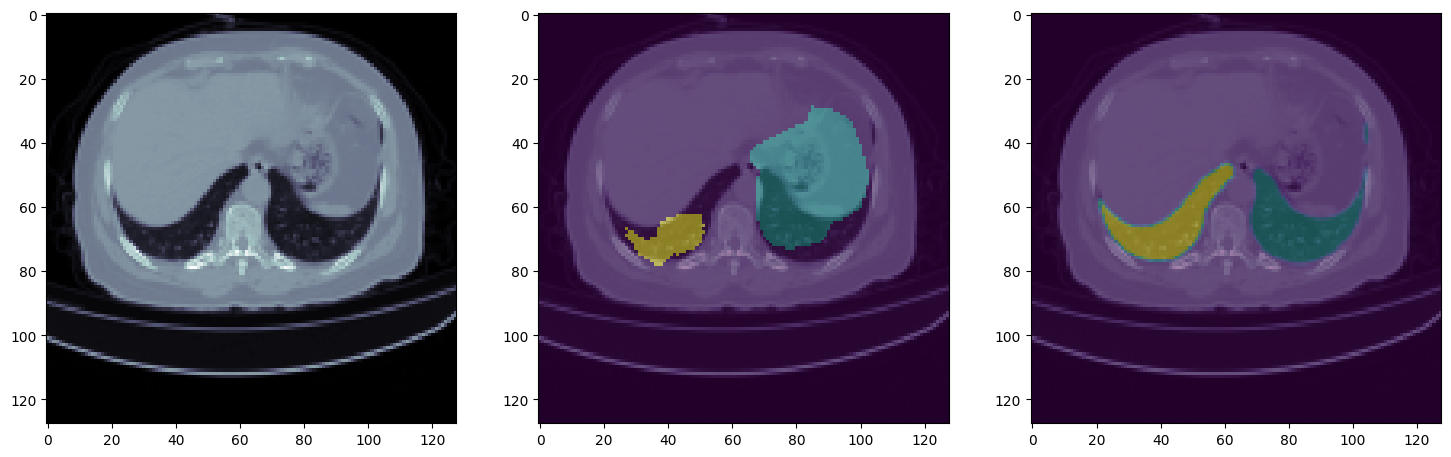

epochs:1/3, image:1/17, batch:160/200, train_loss:0.11196315288543701, test_loss:0.09593993425369263


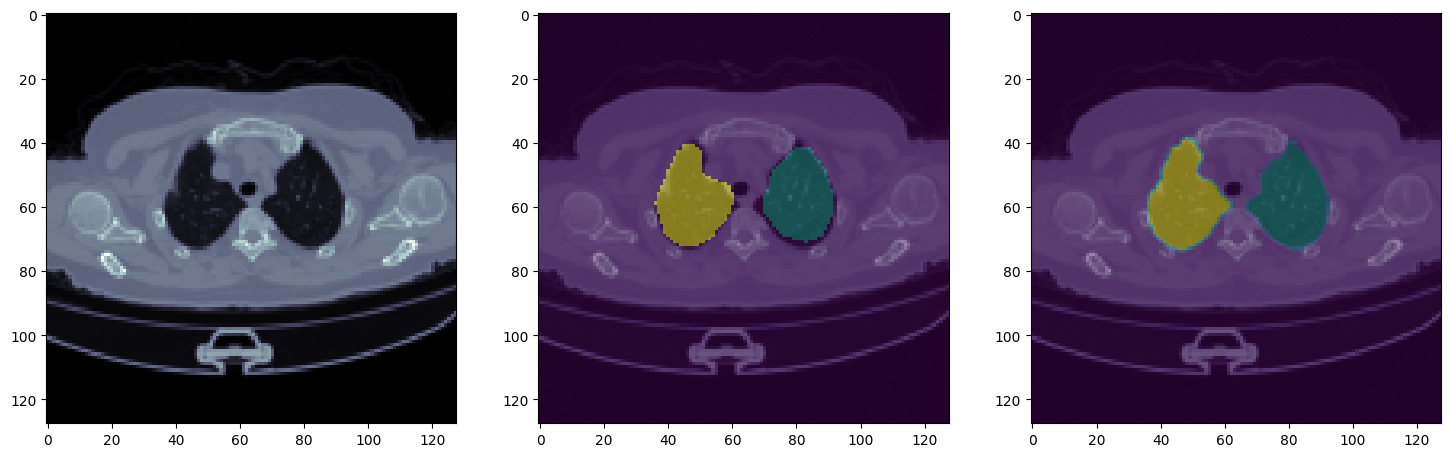

epochs:1/3, image:2/17, batch:256/270, train_loss:1.691322684288025, test_loss:0.10787215083837509


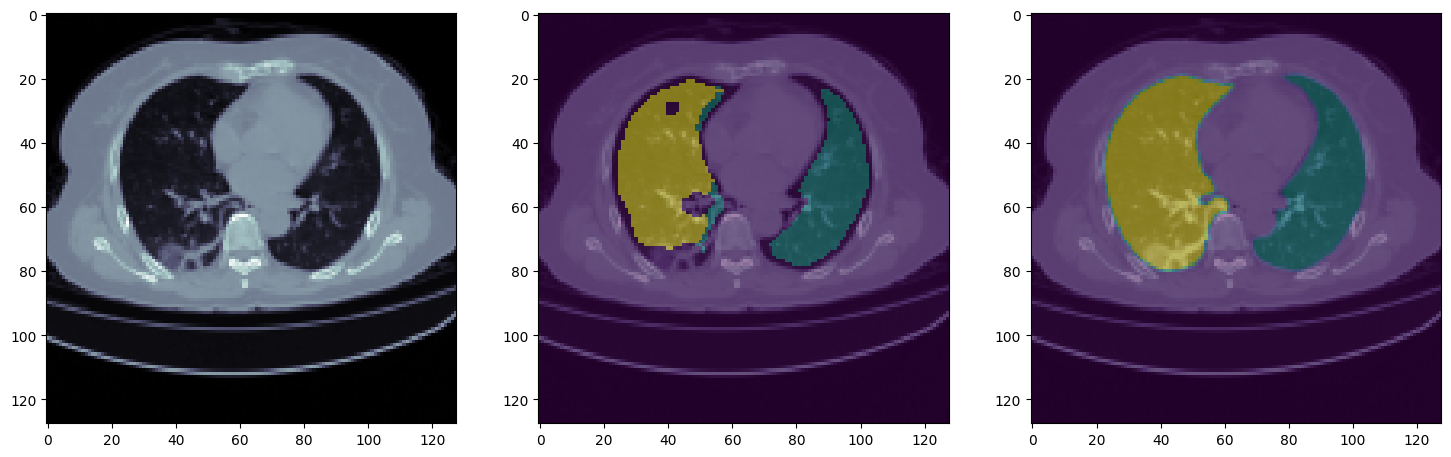

epochs:1/3, image:3/17, batch:288/290, train_loss:1.0384852886199951, test_loss:0.12538549304008484


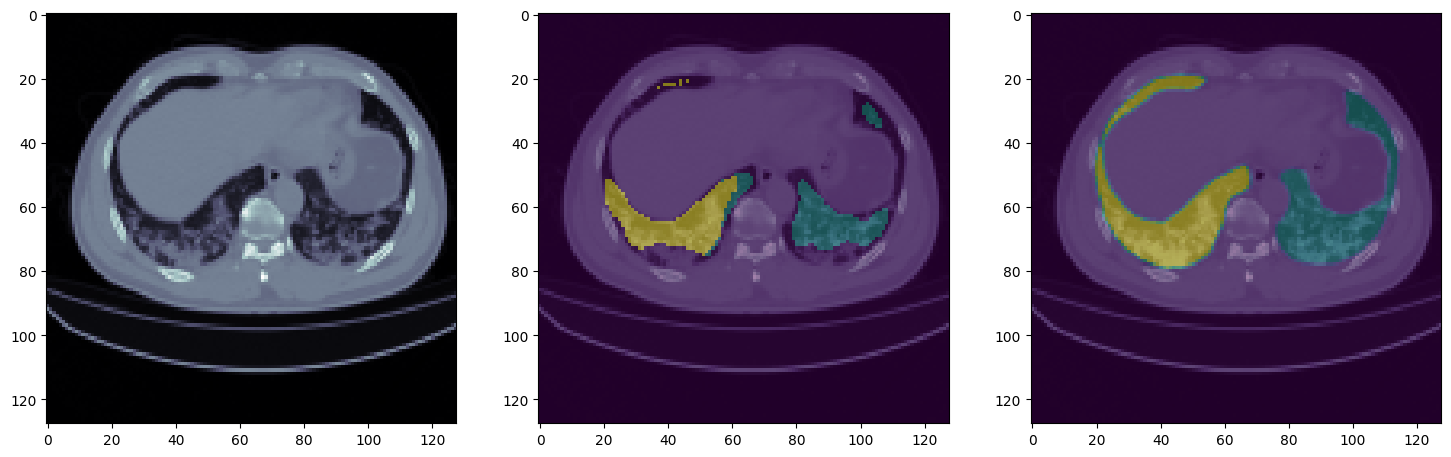

epochs:1/3, image:5/17, batch:64/249, train_loss:0.0918518677353859, test_loss:0.3948870003223419


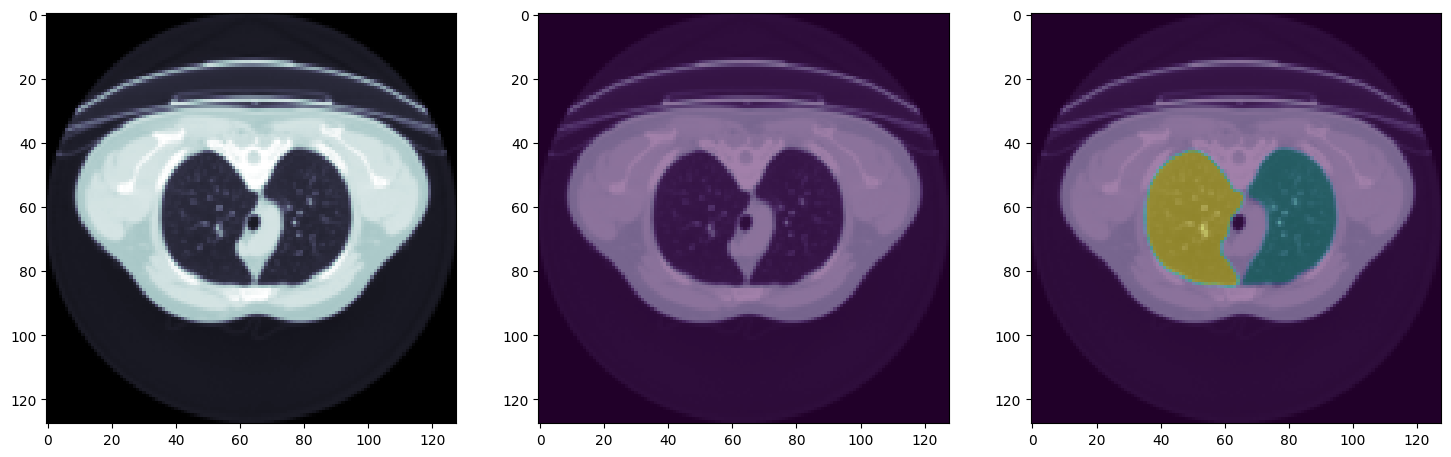

epochs:1/3, image:6/17, batch:128/301, train_loss:0.08515485376119614, test_loss:0.0759970173239708


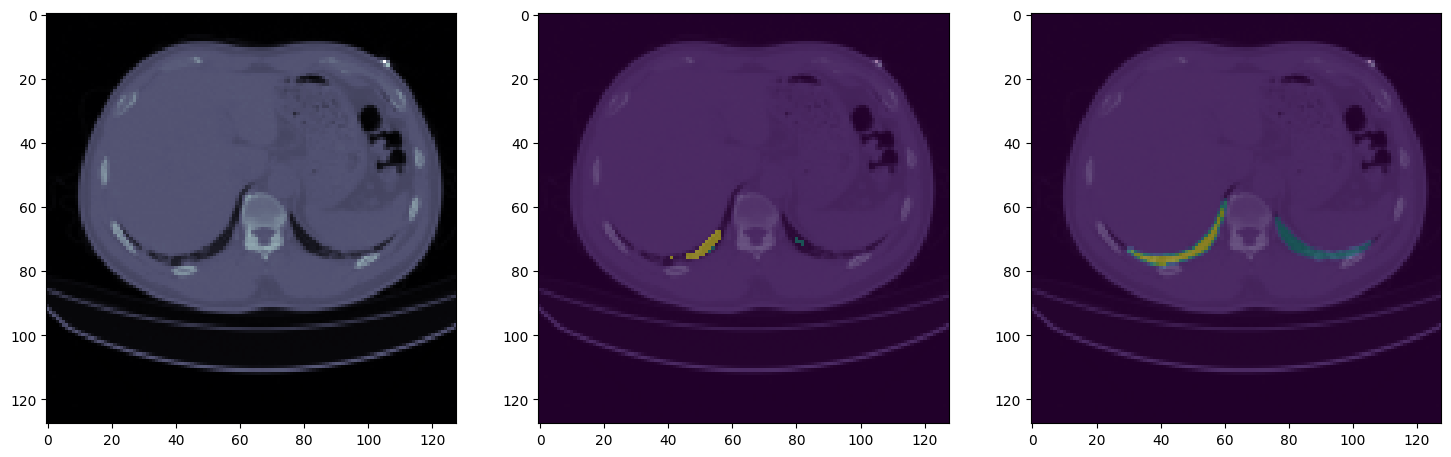

epochs:1/3, image:7/17, batch:128/301, train_loss:0.07809384912252426, test_loss:0.08750385791063309


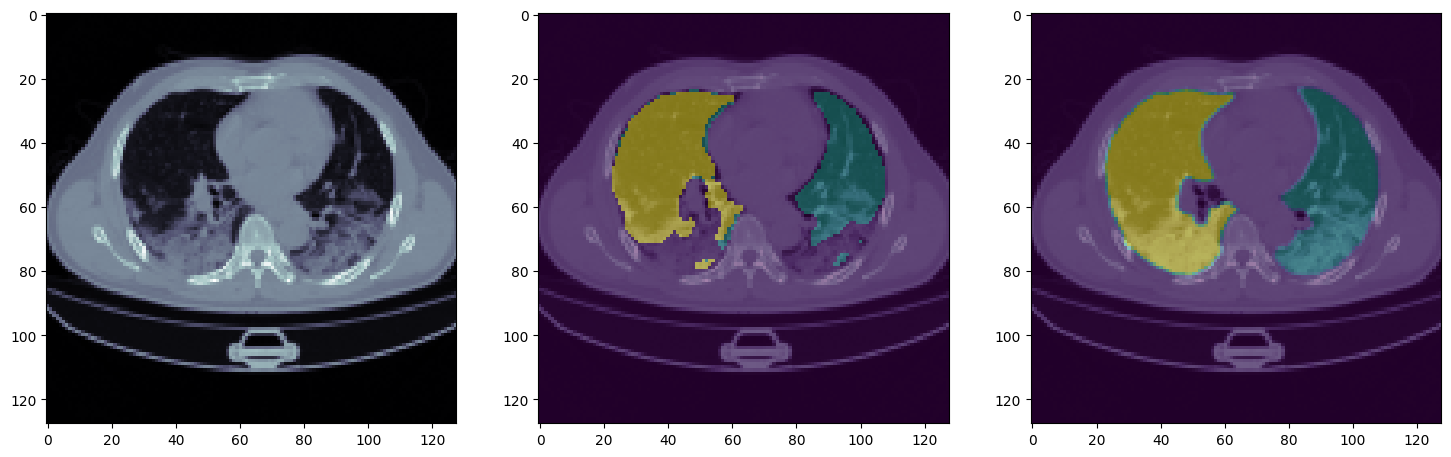

epochs:1/3, image:9/17, batch:64/418, train_loss:0.11192382127046585, test_loss:0.30639415979385376


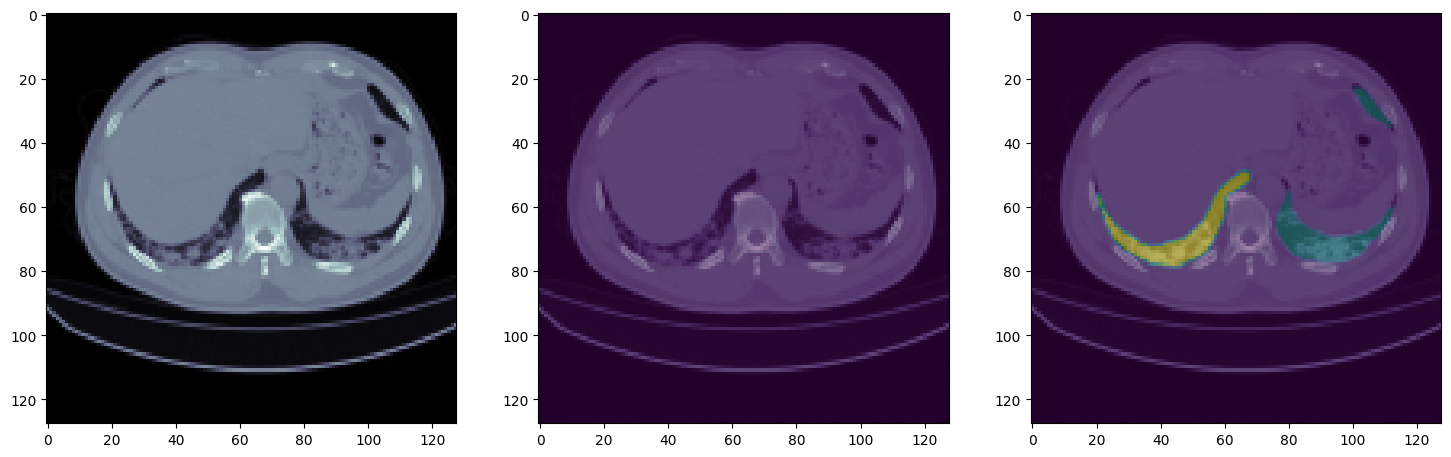

epochs:1/3, image:9/17, batch:384/418, train_loss:0.0667448565363884, test_loss:0.6152482628822327


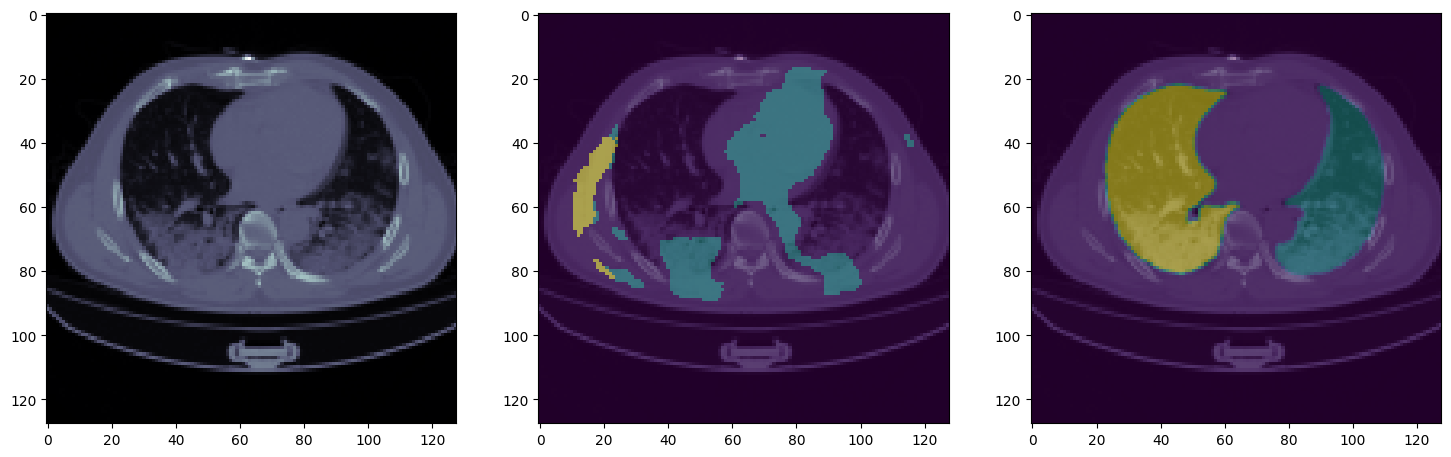

epochs:1/3, image:12/17, batch:32/42, train_loss:1.6185541152954102, test_loss:1.0931957960128784


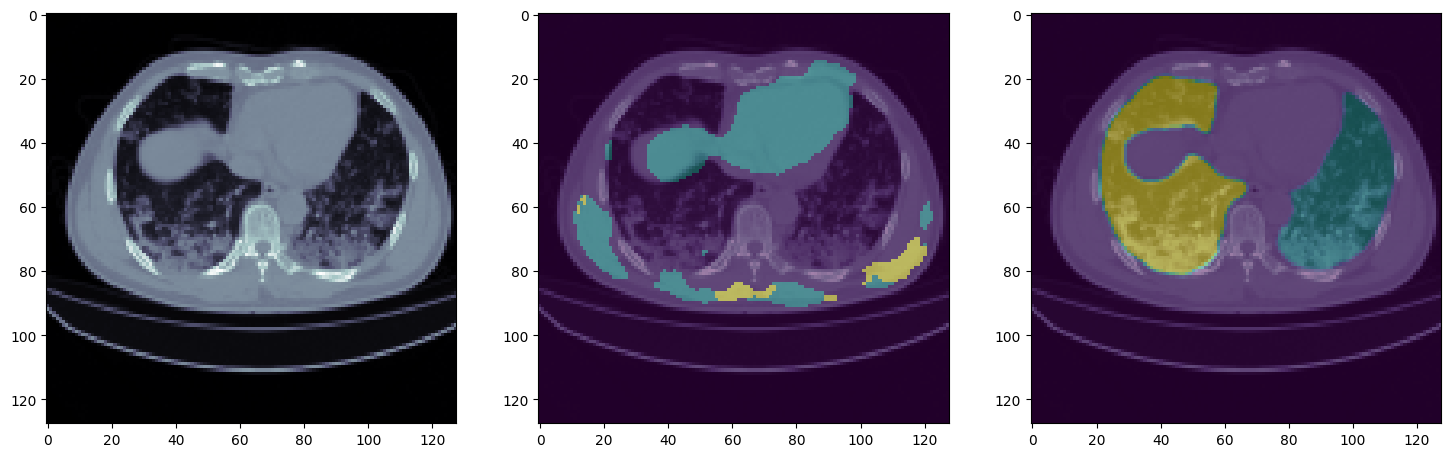

epochs:2/3, image:0/17, batch:0/301, train_loss:0.19874778389930725, test_loss:0.7450191974639893


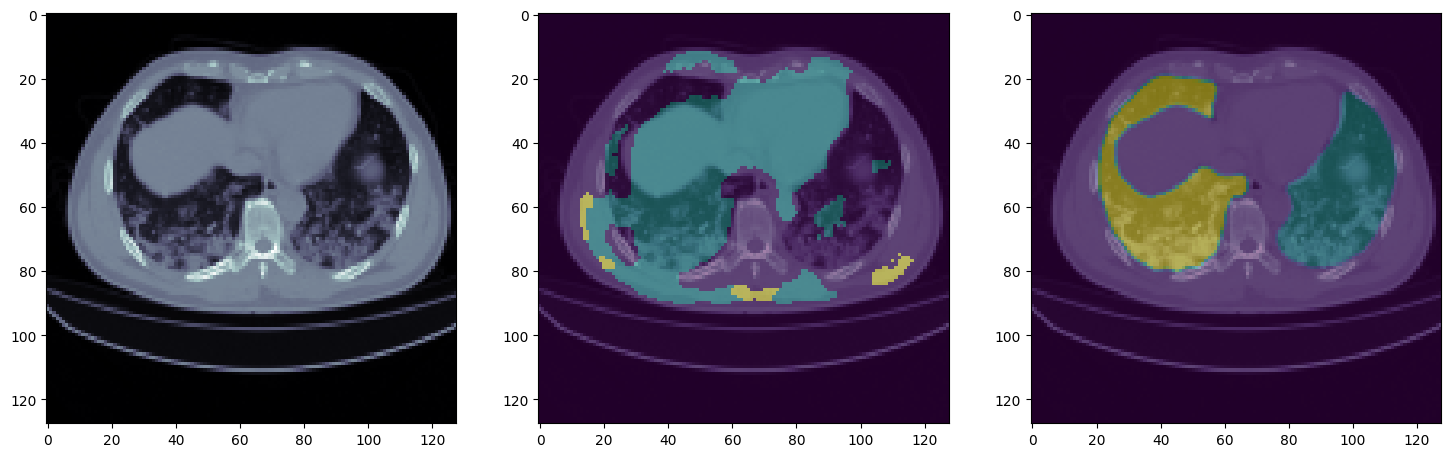

epochs:2/3, image:1/17, batch:0/200, train_loss:0.12002976983785629, test_loss:0.5005984306335449


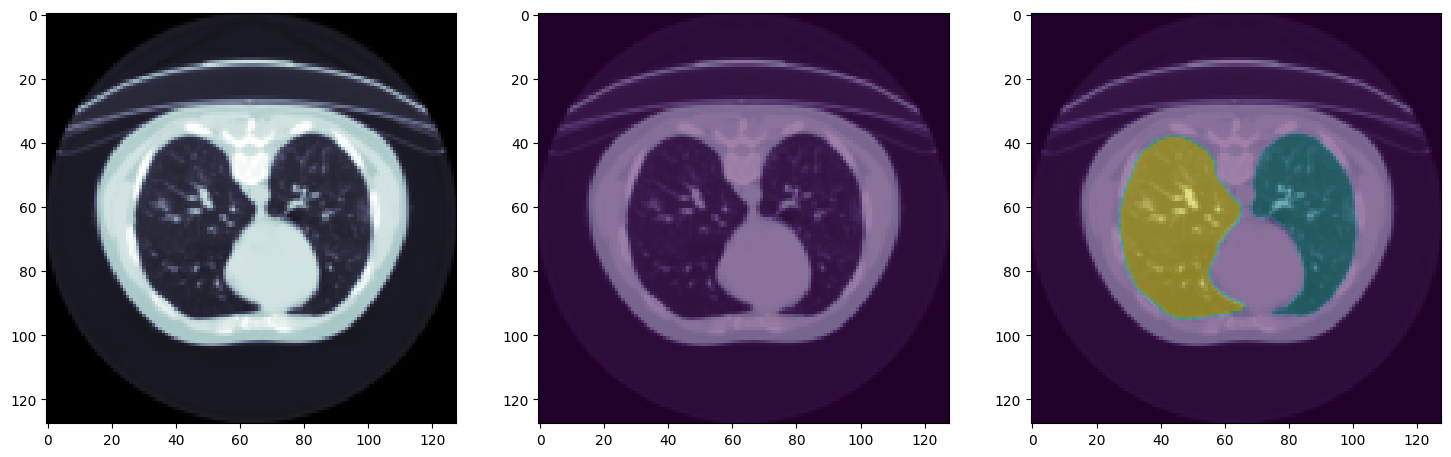

epochs:2/3, image:2/17, batch:96/270, train_loss:0.08440202474594116, test_loss:0.3781173825263977


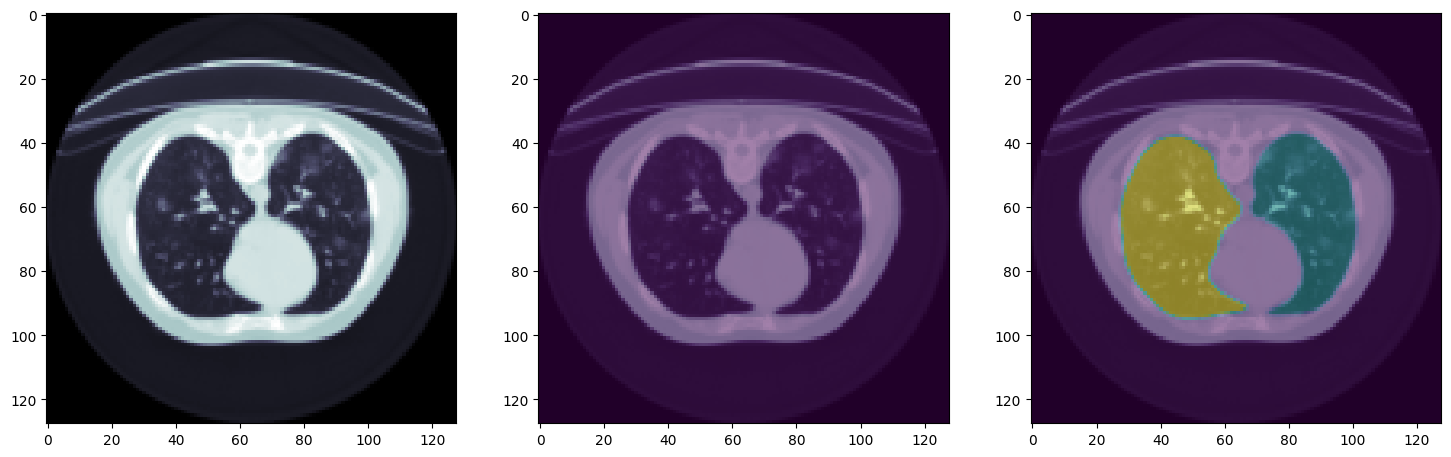

epochs:2/3, image:3/17, batch:128/290, train_loss:0.08355790376663208, test_loss:0.05947740748524666


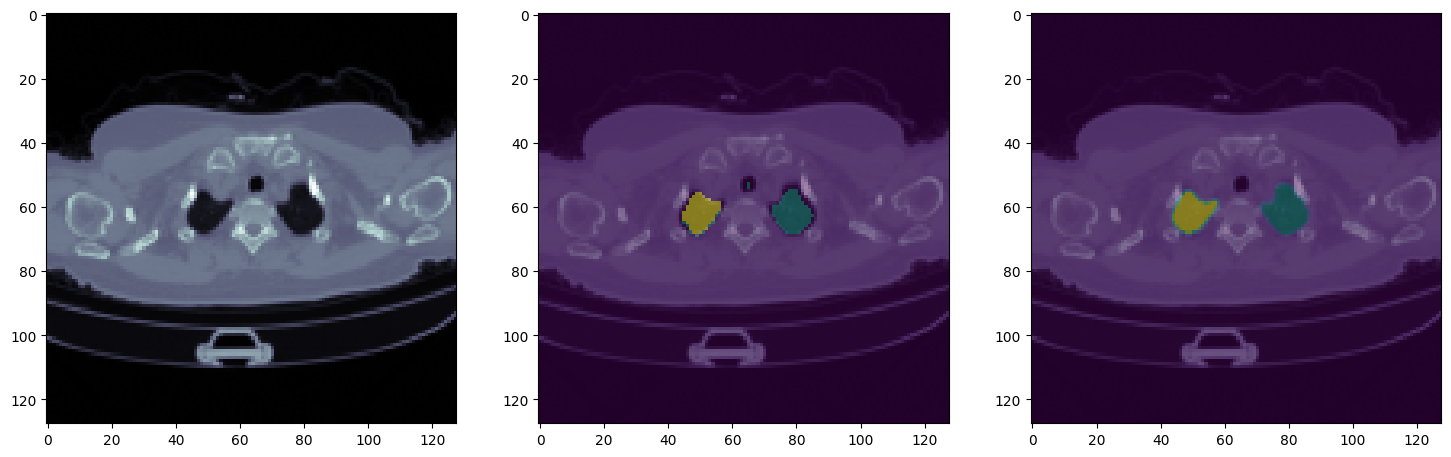

epochs:2/3, image:4/17, batch:128/213, train_loss:0.056941550225019455, test_loss:0.09516087174415588


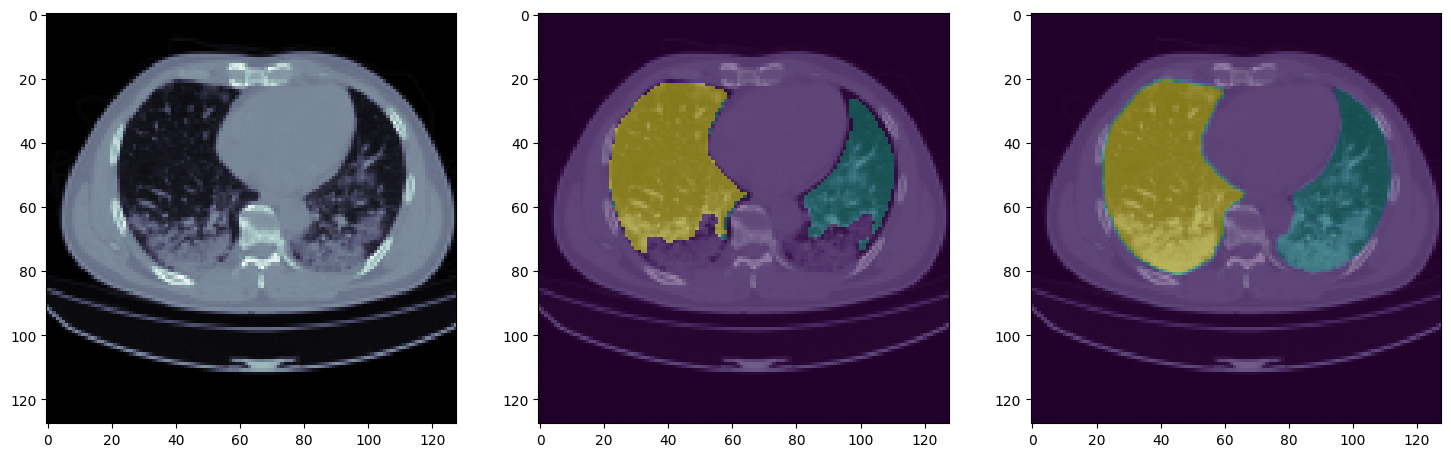

epochs:2/3, image:5/17, batch:224/249, train_loss:1.9690824747085571, test_loss:0.07523595541715622


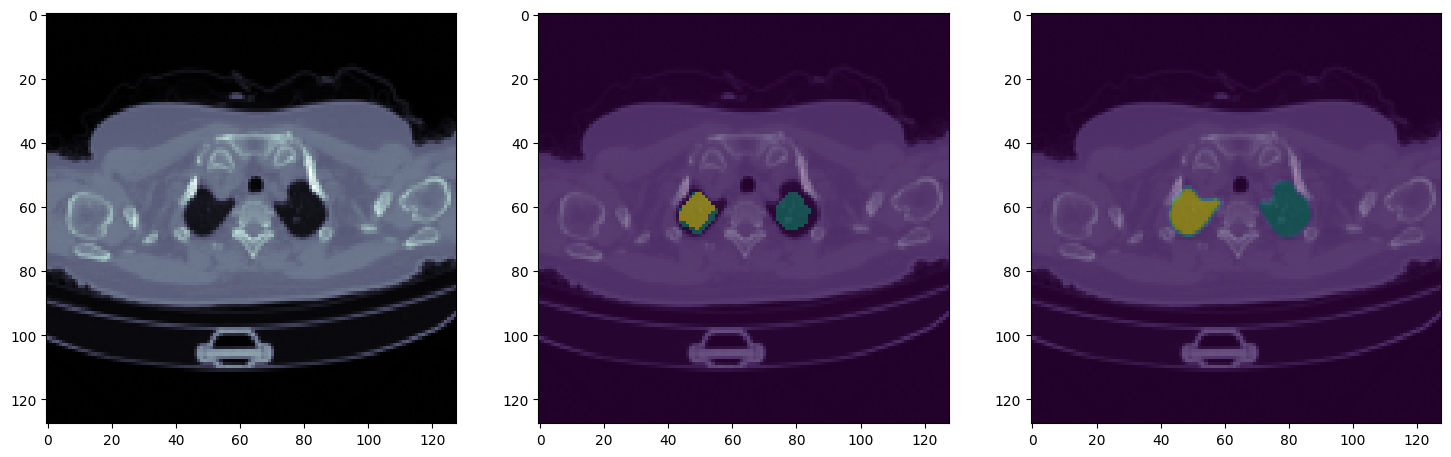

epochs:2/3, image:6/17, batch:288/301, train_loss:1.552504301071167, test_loss:0.08227448165416718


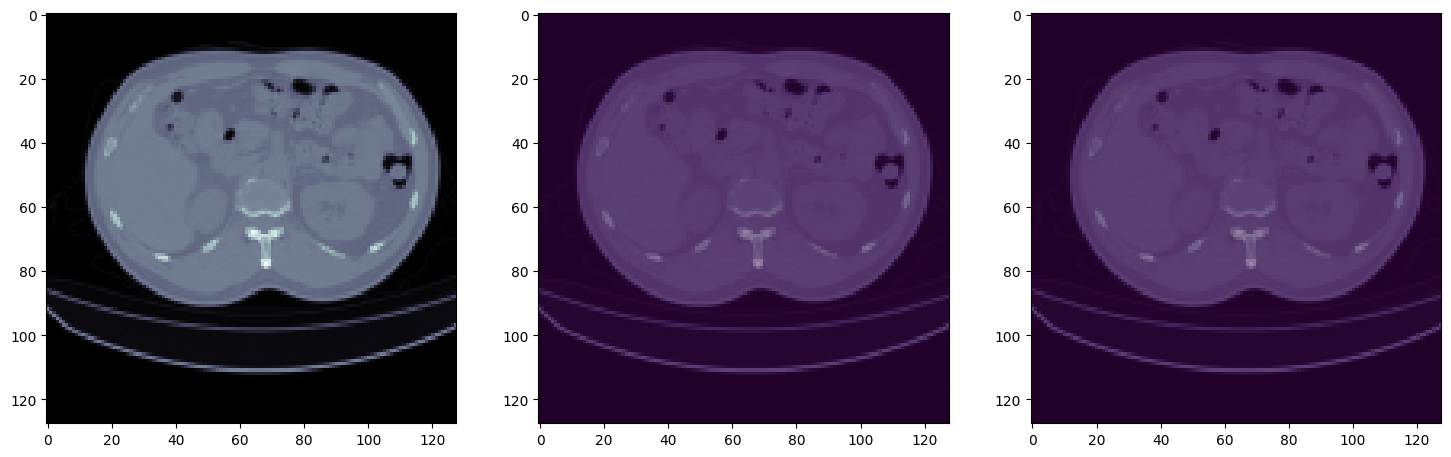

epochs:2/3, image:7/17, batch:288/301, train_loss:1.5785921812057495, test_loss:0.08318839222192764


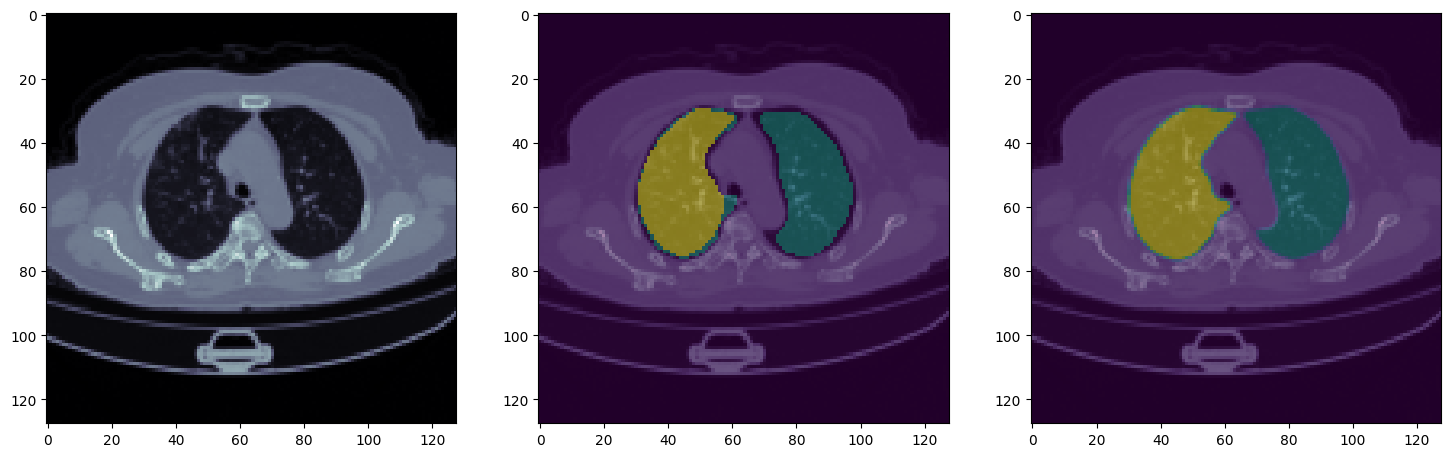

epochs:2/3, image:9/17, batch:224/418, train_loss:0.15060029923915863, test_loss:0.45460885763168335


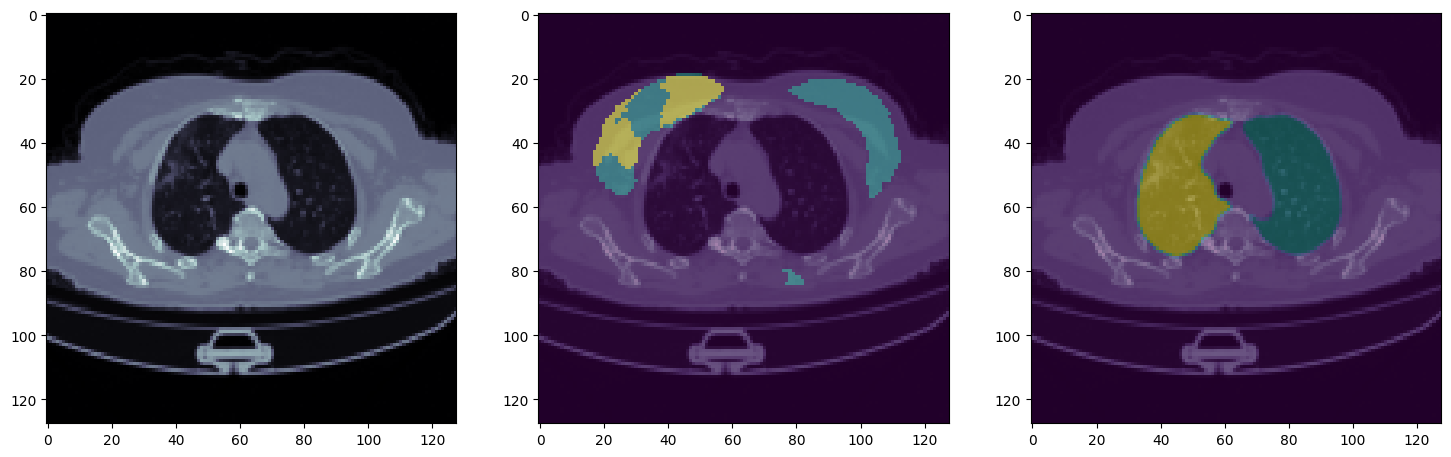

epochs:2/3, image:10/17, batch:96/110, train_loss:1.8647305965423584, test_loss:0.42128658294677734


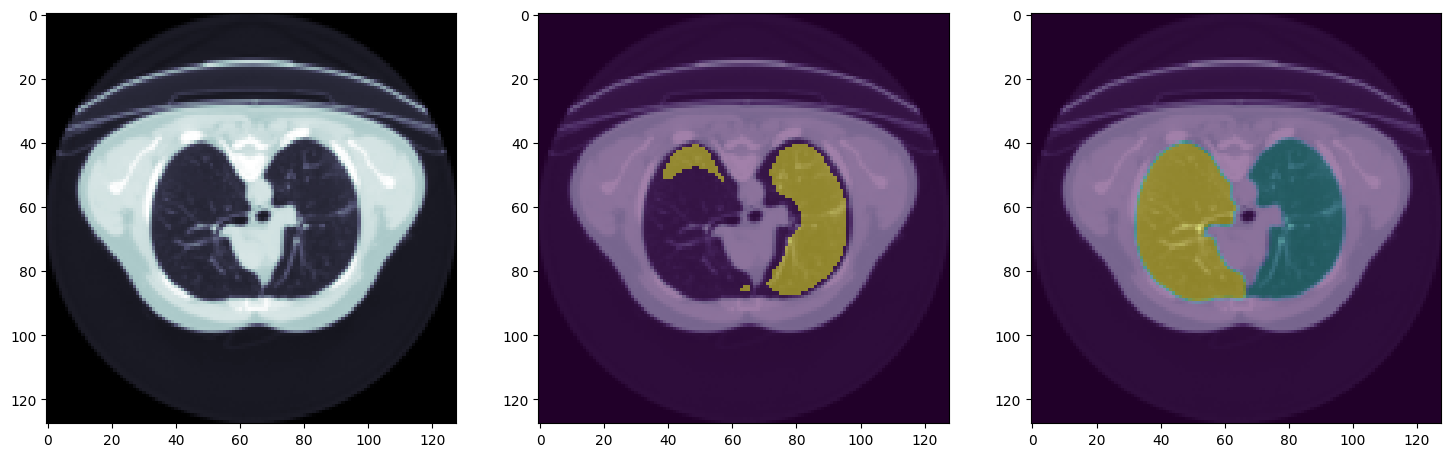

epochs:2/3, image:14/17, batch:64/93, train_loss:2.0802903175354004, test_loss:0.32960331439971924


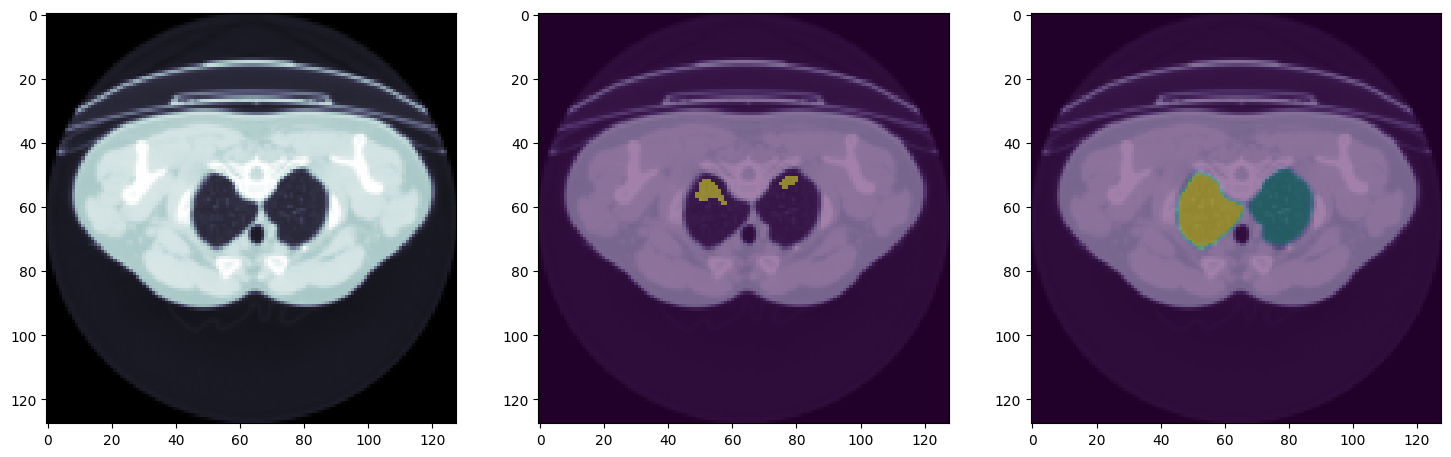

In [ ]:
it=0

for epoch in range(epochs):
  for index,(image,label) in enumerate(zip(X_train,y_train)):
    for batch in range(0,len(image),batch_size):
      model.train()

      batch_image=image[batch:batch+batch_size]
      batch_label=label[batch:batch+batch_size]

      batch_pred=model(batch_image.to(device).unsqueeze(dim=1).to(torch.float32))
      batch_loss=loss_fn(batch_pred.view(batch_size,3,-1),batch_label.view(batch_size,-1).to(device).to(torch.int64))

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

      if it%10==0:
        model.eval()
        with torch.inference_mode():
          image_index=torch.randint(len(X_test),size=(1,))
          random_image=X_test[image_index]
          random_label=y_test[image_index]
          random_index=torch.randint(len(random_image),size=(batch_size,))
          test_image=random_image[random_index]
          test_label=random_label[random_index]
          test_pred=model(test_image.to(device).unsqueeze(dim=1).to(torch.float32))
          test_loss=loss_fn(test_pred.view(batch_size,3,-1),test_label.view(batch_size,-1).to(device).to(torch.int64))
          print(f"epochs:{epoch}/{epochs}, image:{index}/{len(X_train)}, batch:{batch}/{len(image)}, train_loss:{batch_loss}, test_loss:{test_loss}")
          plot_random_index=torch.randint(len(test_image),size=(1,))
          # print(test_image.shape,test_pred[plot_random_index].shape,test_label.shape)
          plot_pred(test_image[plot_random_index].squeeze(),test_pred[plot_random_index].squeeze(),test_label[plot_random_index].squeeze())
          # print(test_pred[plot_random_index].argmax(dim=0))
      it=it+1





In [ ]:
for x in X_test:
  print(x.shape)

torch.Size([256, 128, 128])
torch.Size([200, 128, 128])
torch.Size([45, 128, 128])
torch.Size([200, 128, 128])


In [ ]:
for x in X_train:
  print(x.shape)

torch.Size([301, 128, 128])
torch.Size([200, 128, 128])
torch.Size([270, 128, 128])
torch.Size([290, 128, 128])
torch.Size([213, 128, 128])
torch.Size([249, 128, 128])
torch.Size([301, 128, 128])
torch.Size([301, 128, 128])
torch.Size([39, 128, 128])
torch.Size([418, 128, 128])
torch.Size([110, 128, 128])
torch.Size([66, 128, 128])
torch.Size([42, 128, 128])
torch.Size([42, 128, 128])
torch.Size([93, 128, 128])
torch.Size([39, 128, 128])
torch.Size([45, 128, 128])


In [ ]:
test_index

tensor([ 8,  2, 16,  2])

torch.Size([26, 3, 128, 128])


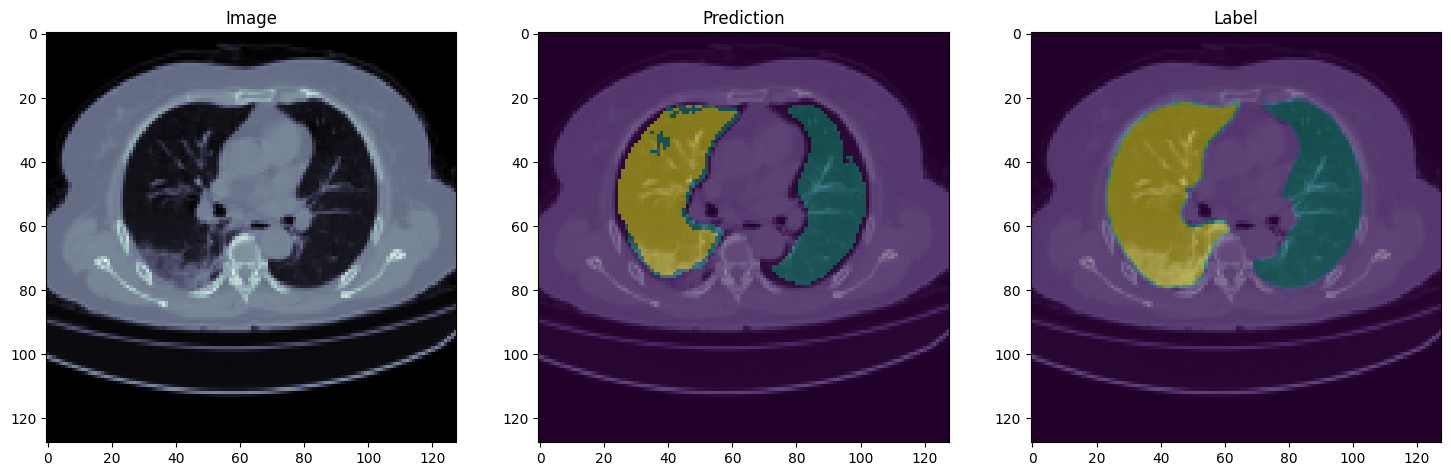

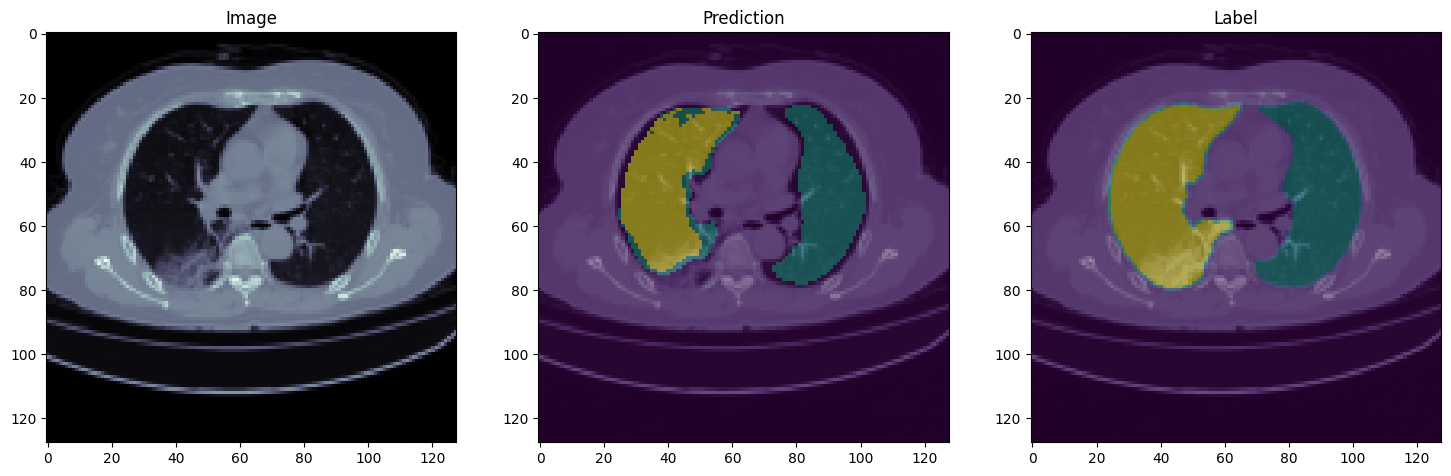

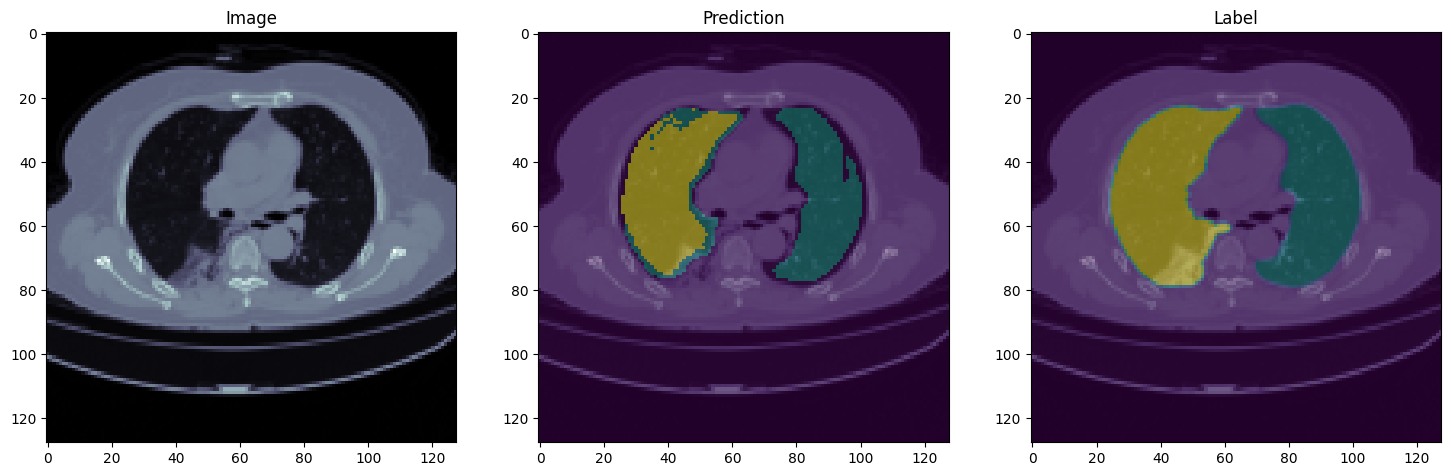

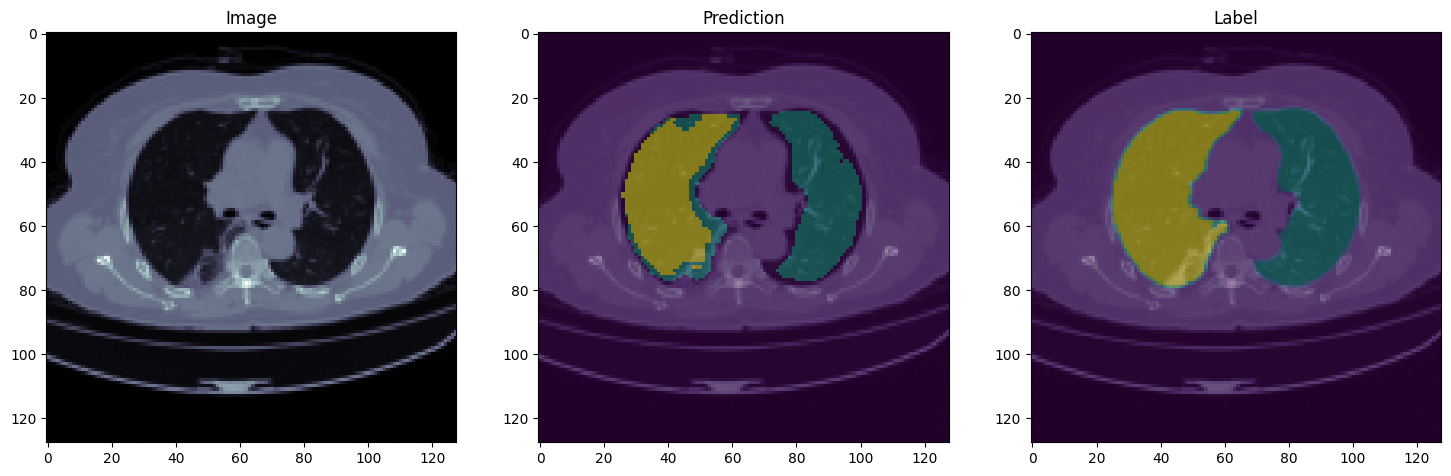

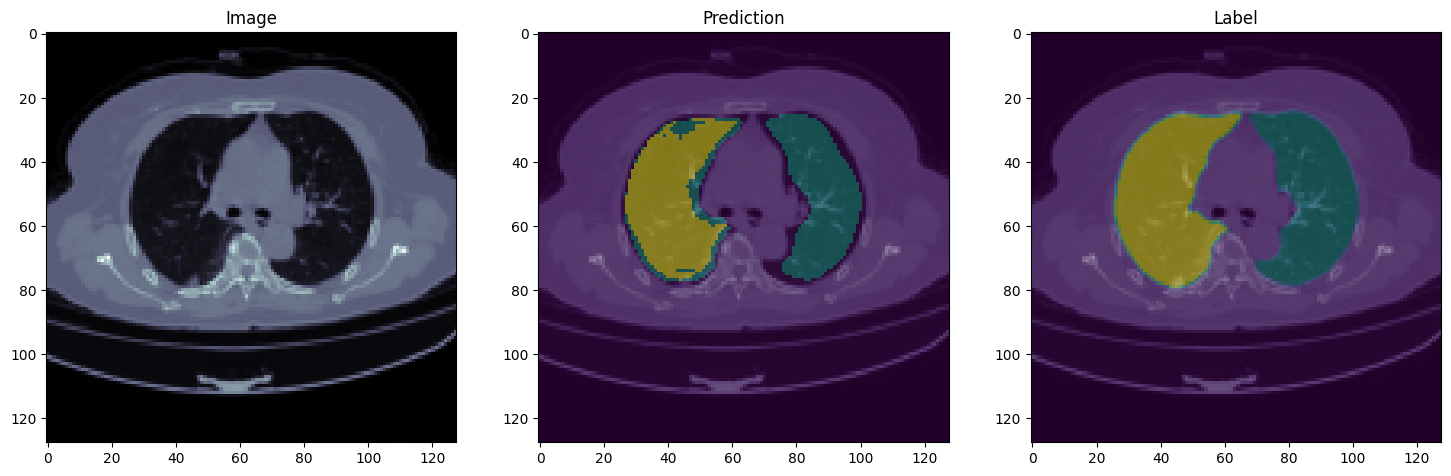

In [ ]:
pred=model(X_test[0][124:150].to(device).unsqueeze(dim=1).to(torch.float32))
print(pred.shape)
for i,j in zip(range(124,150,5),range(1,6)):
  plot_pred(X_test[0][i],pred[i-124],y_test[0][i])

In [ ]:
!mkdir model

In [ ]:
torch.save(model.state_dict(),'model/model.pth')

In [ ]:
loaded_model=UNet(1,3).to(device)
loaded_model.load_state_dict(torch.load('/content/unet_model_state_dict.pth'))

<All keys matched successfully>

torch.Size([26, 3, 128, 128])


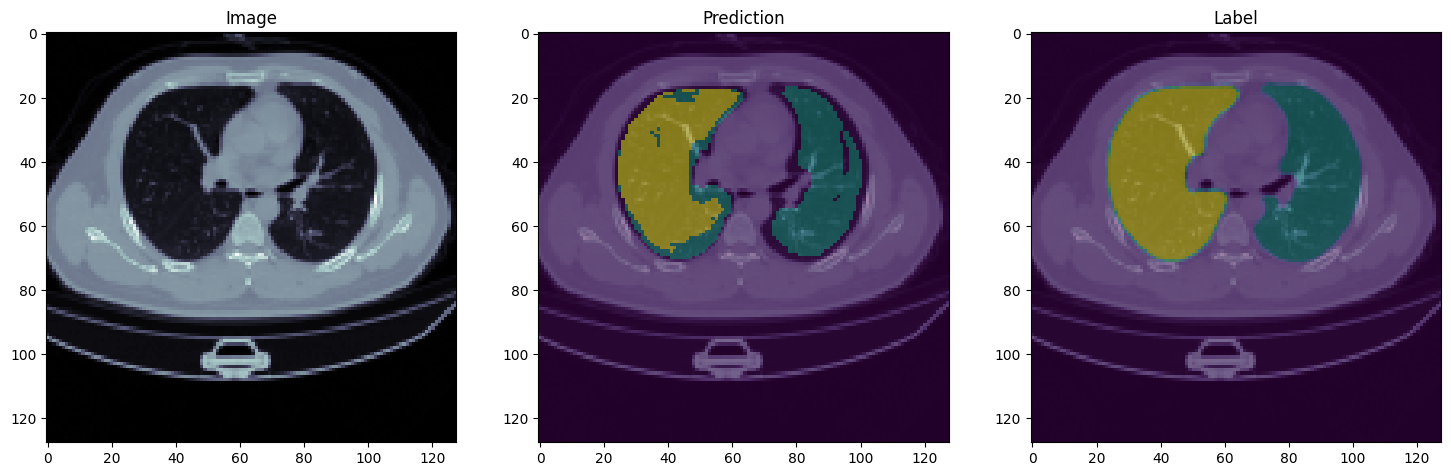

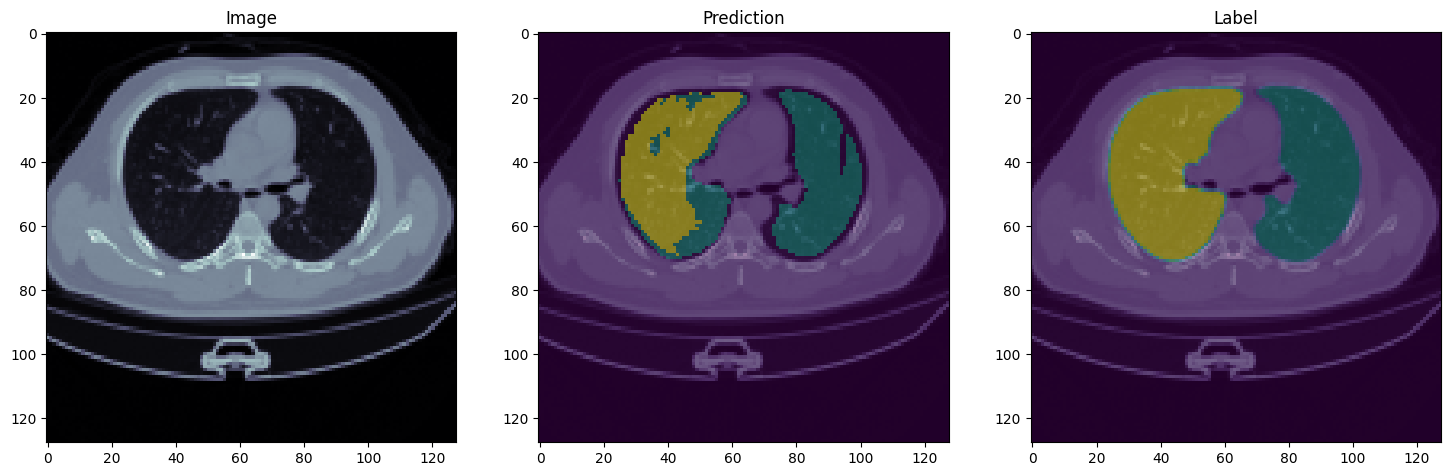

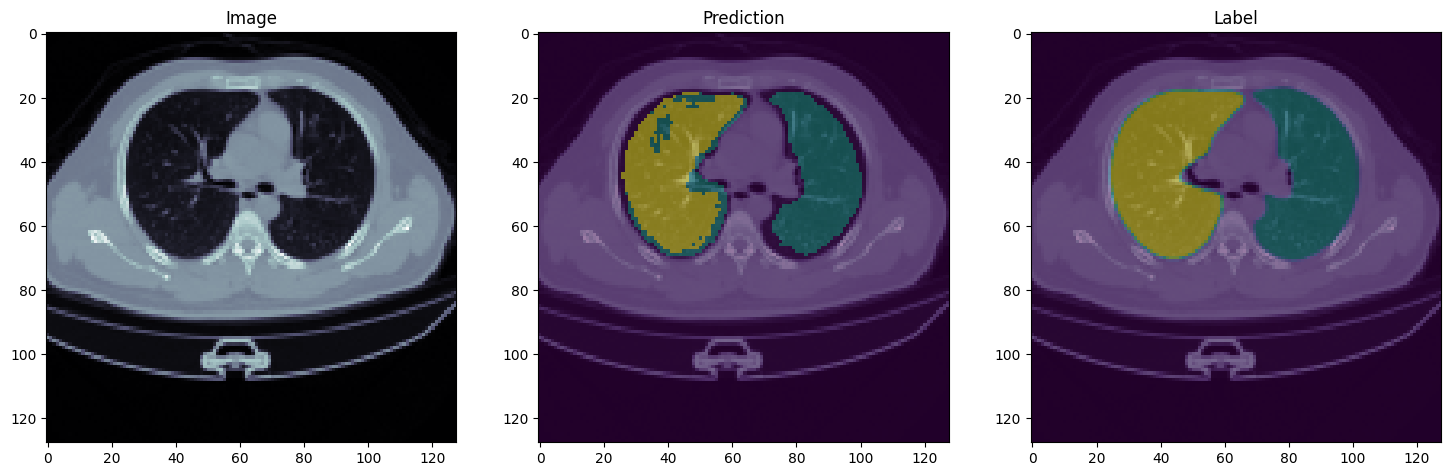

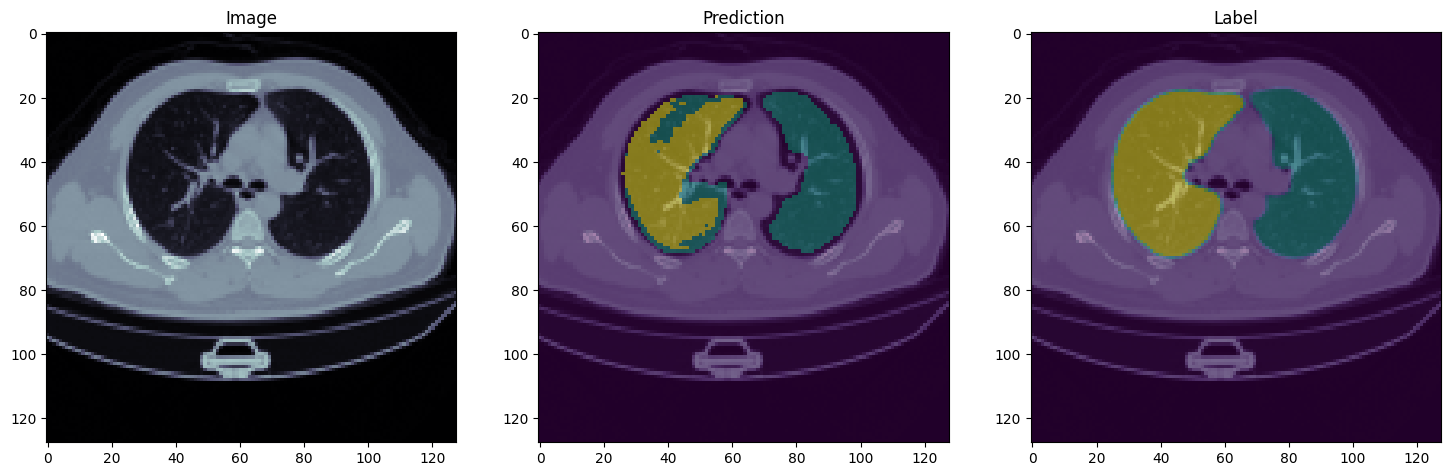

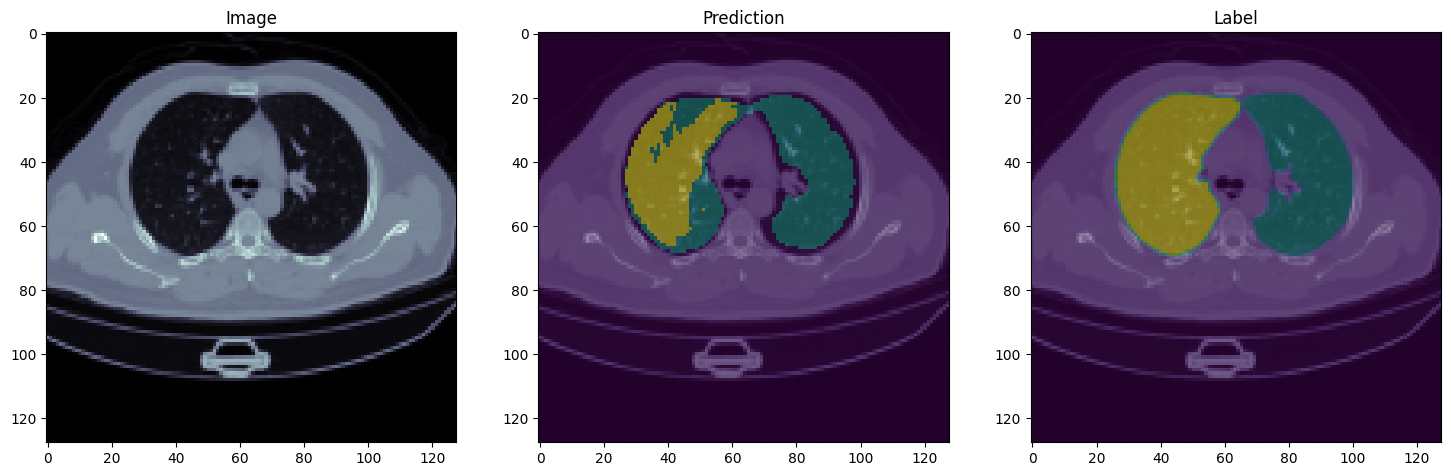

In [ ]:
pred=loaded_model(X_test[0][124:150].to(device).unsqueeze(dim=1).to(torch.float32))
print(pred.shape)
for i,j in zip(range(124,150,5),range(1,6)):
  plot_pred(X_test[0][i],pred[i-124],y_test[0][i])